### Data simulation framework

In [1]:
import pickle
from os.path import join
from os import makedirs
import pandas as pd
from collections import defaultdict
import seaborn as sns
import numpy as np
from tqdm import tqdm
from itertools import permutations
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder as le
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
from utils.io import save_pkl
from utils.constants import DATA_DIR

### Generic plotting, saving and other helper functions

In [3]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'medium',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [4]:
def plot_2d_distribution(data, color):
    assert isinstance(data, np.ndarray) and data.shape[1] == 2

    df = pd.DataFrame(data, columns=["x", "y"])
    g = sns.jointplot(x="x", y="y", data=df, kind="kde")
    g.plot_joint(plt.scatter, c=color, s=30, linewidth=2, marker="o")
    g.ax_joint.collections[0].set_alpha(0)
    g.set_axis_labels("$X_{1}$", "$X_{2}$")
    plt.grid()

In [5]:
def evaluate_simulated_data_by_correlation(simulated_correlation_matrix, input_correlation_matrix, show=False):
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    
    fig = plt.figure(figsize=(17, 7))
    gs = gridspec.GridSpec(nrows=1, ncols=2)
    
    ax1 = fig.add_subplot(gs[0])
    sns.heatmap(input_correlation_matrix, vmin=0.0, vmax=1.0, ax=ax1, cmap=cmap, annot=show)
    ax1.set_title("Correlation of original data")

    ax2 = fig.add_subplot(gs[1])
    sns.heatmap(simulated_correlation_matrix, vmin=0.0, vmax=1.0, ax=ax2, cmap=cmap, annot=show)
    ax2.set_title("Correlation of simulated data")
    
    plt.show()

In [6]:
def save_synthetic_dataset(dataset, name):
    assert isinstance(dataset, defaultdict)
    
    save_dir = join(DATA_DIR, 'synthetic', name)
    makedirs(save_dir, exist_ok=True)
    
    save_path = join(save_dir, 'cleaned.pkl')
    save_pkl(dataset, save_path)

In [7]:
def load_uniform_correlation_matrix(dimension, level='none', min_=None, max_=None, max_iter=100):
    
    if min_ is None and max_ is None:
        assert level in ['low', 'mid', 'high']

        if level == 'low':
            min_, max_ = 0.1, 0.3
        elif level == 'mid':
            min_, max_ = 0.45, 0.65
        else:
            min_, max_ = 0.8, 0.95

    C = np.zeros((dimension, dimension))
    return_seed = -1 # not found any psd matrix in max_iters

    for i in range(max_iter):
        seed = i + 1
        
        np.random.seed(seed)
        C = np.random.uniform(min_, max_, size=(dimension, dimension))
        np.fill_diagonal(C, 1.0)

        try:
            L = np.linalg.cholesky(C)
            return_seed = seed
            
            return C, return_seed
        except:
            continue
        
        return C, return_seed

In [8]:
def load_dual_correlation_matrix(dimension, corr_target, corr_sensitive, fraction=0.4, delta=0.05,
                                 max_iter=100, global_min=0.05, global_max=0.25):
    
    subset_index = int(fraction * dimension)
    
    C = np.zeros((dimension, dimension))
    return_seed = -1 # not found any psd matrix in max_iters

    for i in range(max_iter):
        seed = i + 1
        
        np.random.seed(seed)
        C = np.random.uniform(global_min, global_max, size=(dimension, dimension))

        max_, min_ = corr_target + delta, corr_target - delta
        C[:subset_index, :subset_index] = np.random.uniform(min_, max_, size=(subset_index, subset_index))

        max_, min_ = corr_sensitive + delta, corr_sensitive - delta
        C[-subset_index:, -subset_index:] = np.random.uniform(min_, max_, size=(subset_index, subset_index))
        
        np.fill_diagonal(C, 1.0)

        try:
            L = np.linalg.cholesky(C)
            return_seed = seed
            
            return C, return_seed
        except:
            continue
        
        return C, return_seed

In [9]:
def load_nonuniform_correlation_matrix(dimension, northwest, southeast, rest, fraction=0.4, delta=0.05, max_iter=100):
    
    C = np.zeros((dimension, dimension))
    return_seed = -1 # not found any psd matrix in max_iters
    
    subset_index = int(fraction * dimension)

    for i in tqdm(range(max_iter)):
        seed = i + 1
        
        np.random.seed(seed)

        max_, min_ = rest + delta, rest - delta
        C = np.random.uniform(min_, max_, size=(dimension, dimension))

        max_, min_ = northwest + delta, northwest - delta
        C[:subset_index, :subset_index] = np.random.uniform(min_, max_, size=(subset_index, subset_index))

        max_, min_ = southeast + delta, southeast - delta
        C[-subset_index:, -subset_index:] = np.random.uniform(min_, max_, size=(subset_index, subset_index))

        np.fill_diagonal(C, 1.0)

        try:
            L = np.linalg.cholesky(C)
            return_seed = seed
            
            return C, return_seed
        except:
            continue
        
    return C, return_seed

In [10]:
x = load_nonuniform_correlation_matrix(dimension=10, northwest=0.3, southeast=0.3, rest=0.7, max_iter=1000000)

100%|██████████| 1000000/1000000 [00:45<00:00, 22148.54it/s]


### Real simulated data

In [11]:
def simulate_multi_dimensional_real_data(num_samples, correlation_matrix, dimension):
    """
    Generates data X such that correlation([X_1, X_2, .., X_dimension]) = correlation_matrix
    """
    assert correlation_matrix.shape == (dimension, dimension)
    
    Q = correlation_matrix.copy()
    D = dimension
    N = num_samples

    L = np.linalg.cholesky(Q)
    
    L_ = np.square(L)
    y = np.ones(D)
    sigmas_2 = np.linalg.solve(L_, y)
    sigmas = np.sqrt(sigmas_2)
    
    Z = np.zeros((N, D))
    
    for d in range(D):
        Z[:, d] = np.random.normal(0, sigmas[d], size=N)
    
    X = np.dot(L, Z.T).T
    
    return X

In [12]:
def simulate_two_dimensional_real_data(num_samples, rho):
    """
    For given correlation(X, Y) = rho, returns 2D data [X, y]
    """
    correlation_matrix = np.array([[1.0, rho], [rho, 1.0]])
    X = simulate_multi_dimensional_real_data(num_samples, correlation_matrix, dimension=2)
    return X

#### 2D Real data

In [15]:
rho_values = np.linspace(0.1, 0.9, 9)

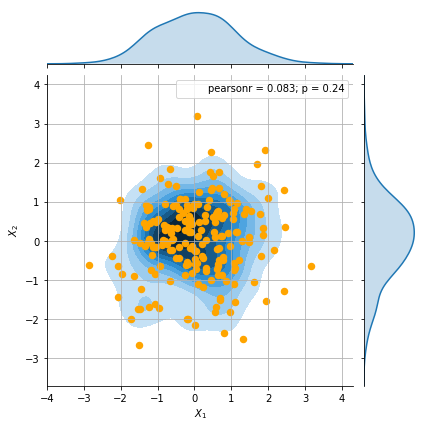

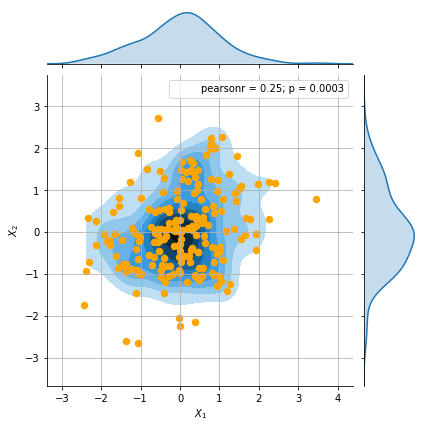

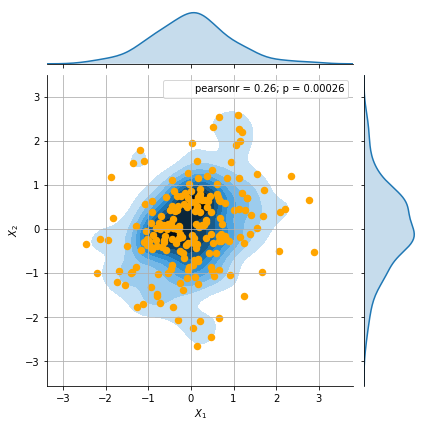

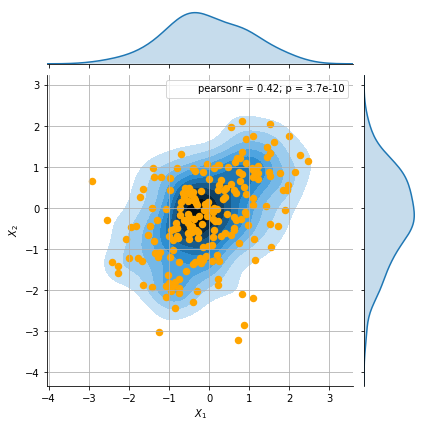

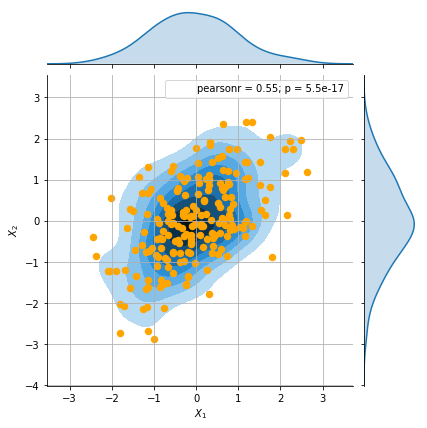

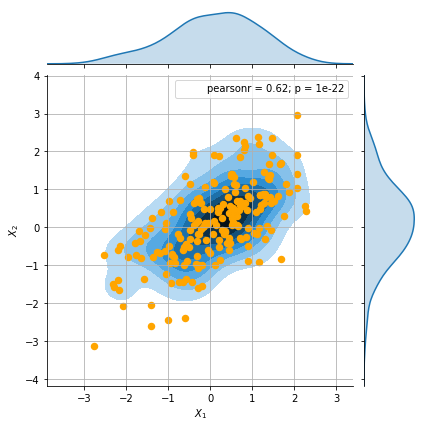

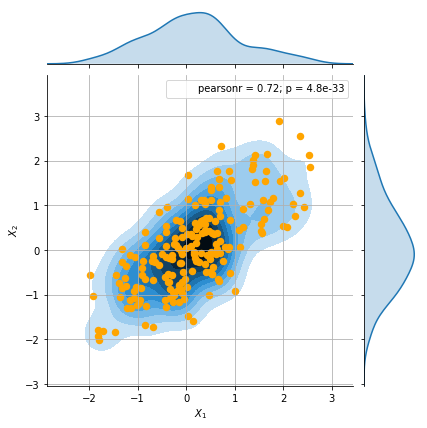

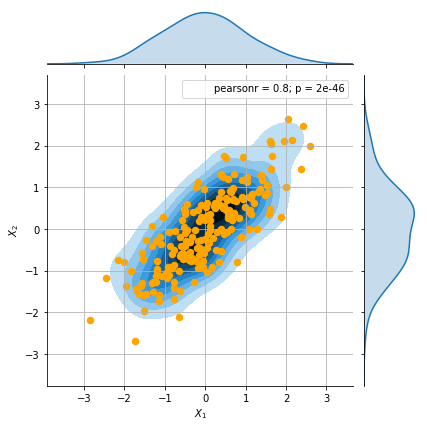

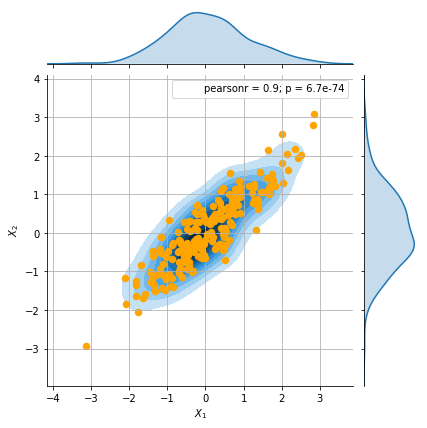

In [25]:
NUM_SAMPLES = 5000
NUM_SAMPLES_TO_VISUALIZE = 200
dataset = defaultdict(dict)

for i, rho in enumerate(rho_values):
    data = simulate_two_dimensional_real_data(NUM_SAMPLES, rho=rho)
    indices = np.random.choice(NUM_SAMPLES, size=NUM_SAMPLES_TO_VISUALIZE, replace=False)
    plot_2d_distribution(data[indices], 'orange');
    data = pd.DataFrame(data, columns=['real-1', 'real-2'])
    dataset[str(i + 1)] = {'rho': rho, 'data': data}

In [26]:
dataset.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [37]:
save_synthetic_dataset(dataset, name='dataset_1')

#### 10D Real data: Uniform correlation matrix

In [13]:
dataset = defaultdict(dict)

DIMENSION = 10
NUM_SAMPLES = 5000

**Case 1: Uniformly low correlation matrix**

In [14]:
C, seed = load_uniform_correlation_matrix(DIMENSION, 'low')

In [15]:
X = simulate_multi_dimensional_real_data(NUM_SAMPLES, C, DIMENSION)

In [16]:
X = pd.DataFrame(X, columns=['real-{}'.format(i + 1) for i in range(X.shape[1])])

In [17]:
C_sim = X.corr(method='pearson')

In [18]:
C = pd.DataFrame(C, columns=C_sim.columns, index=C_sim.columns)

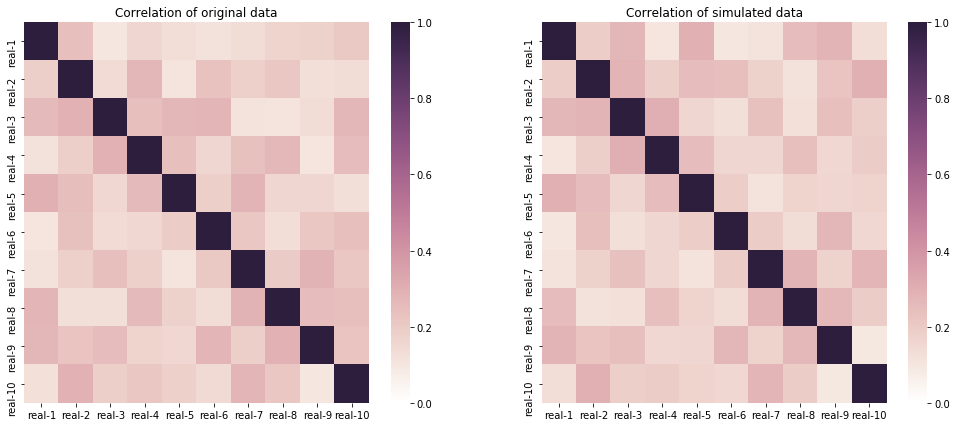

In [19]:
evaluate_simulated_data_by_correlation(C_sim, C)

In [20]:
dataset['low'] = {'data': X, 'seed': seed, 'C_in': C, 'C_sim': C_sim}

**Case 2: Uniformly medium correlation matrix**

In [21]:
C, seed = load_uniform_correlation_matrix(DIMENSION, 'mid')

In [22]:
X = simulate_multi_dimensional_real_data(NUM_SAMPLES, C, DIMENSION)

In [23]:
X = pd.DataFrame(X, columns=['real-{}'.format(i + 1) for i in range(X.shape[1])])

In [24]:
C_sim = X.corr(method='pearson')

In [25]:
C = pd.DataFrame(C, columns=C_sim.columns, index=C_sim.columns)

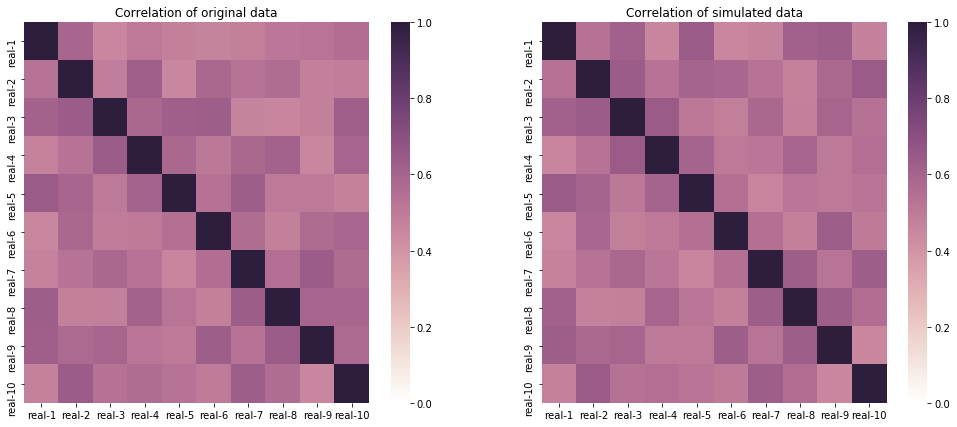

In [26]:
evaluate_simulated_data_by_correlation(C_sim, C)

In [27]:
dataset['mid'] = {'data': X, 'seed': seed, 'C_in': C, 'C_sim': C_sim}

**Case 3: Uniformly high correlation matrix**

In [28]:
C, seed = load_uniform_correlation_matrix(DIMENSION, 'high', max_iter=1000)

In [29]:
X = simulate_multi_dimensional_real_data(NUM_SAMPLES, C, DIMENSION)

In [30]:
X = pd.DataFrame(X, columns=['real-{}'.format(i + 1) for i in range(X.shape[1])])

In [31]:
C_sim = X.corr(method='pearson')

In [32]:
C = pd.DataFrame(C, columns=C_sim.columns, index=C_sim.columns)

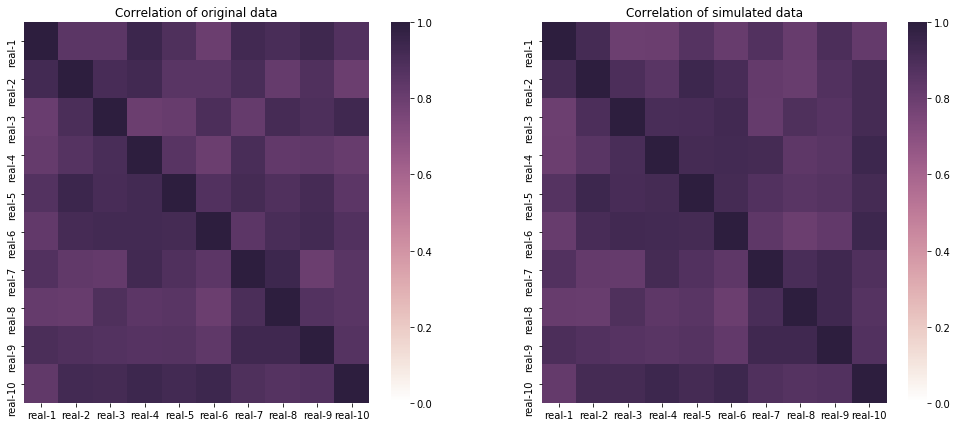

In [33]:
evaluate_simulated_data_by_correlation(C_sim, C)

In [34]:
dataset['high'] = {'data': X, 'seed': seed, 'C_in': C, 'C_sim': C_sim}

In [35]:
save_synthetic_dataset(dataset, name='dataset_2')

#### [Optional] 10D Real: Uniform correlation matrices on continuous spectrum

In [54]:
dataset = defaultdict(dict)

DIMENSION = 10
NUM_SAMPLES = 5000

DELTA = 0.05

In [53]:
variation_centers = np.linspace(0.1, 0.9, 9)

=========== Working for center: 0.1 ============


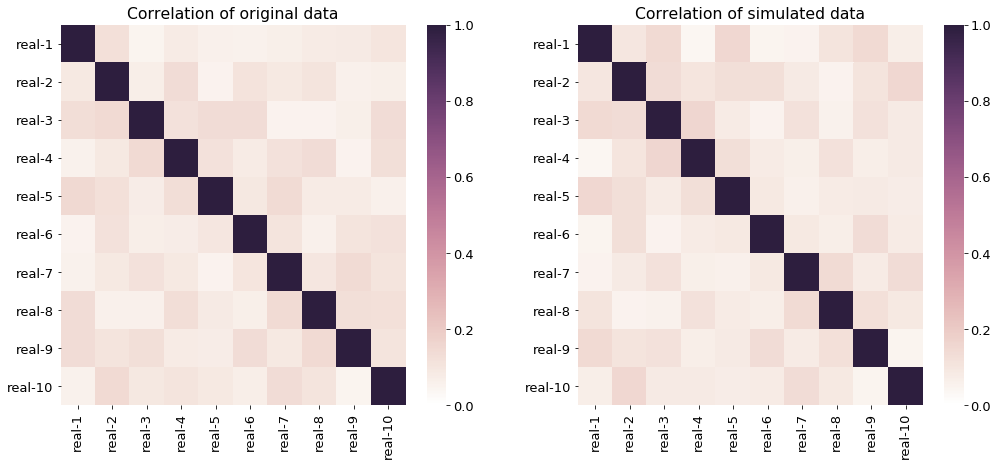

=========== Working for center: 0.2 ============


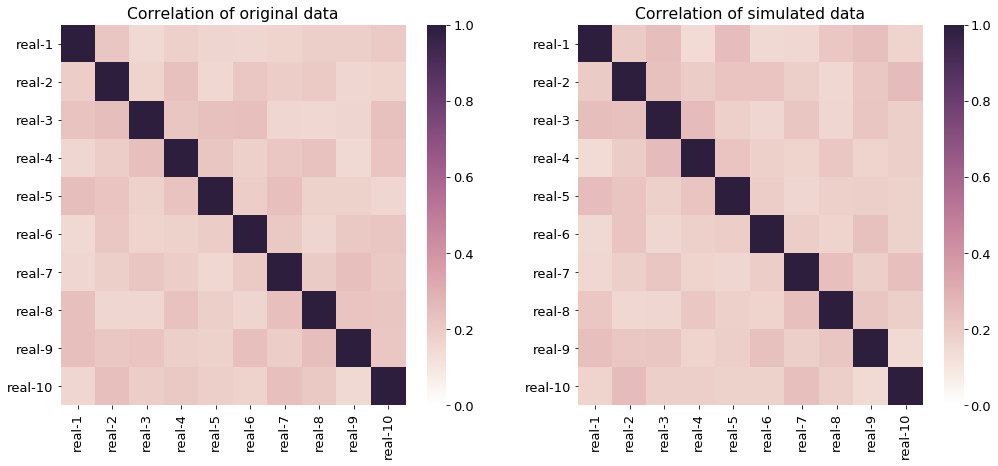

=========== Working for center: 0.30000000000000004 ============


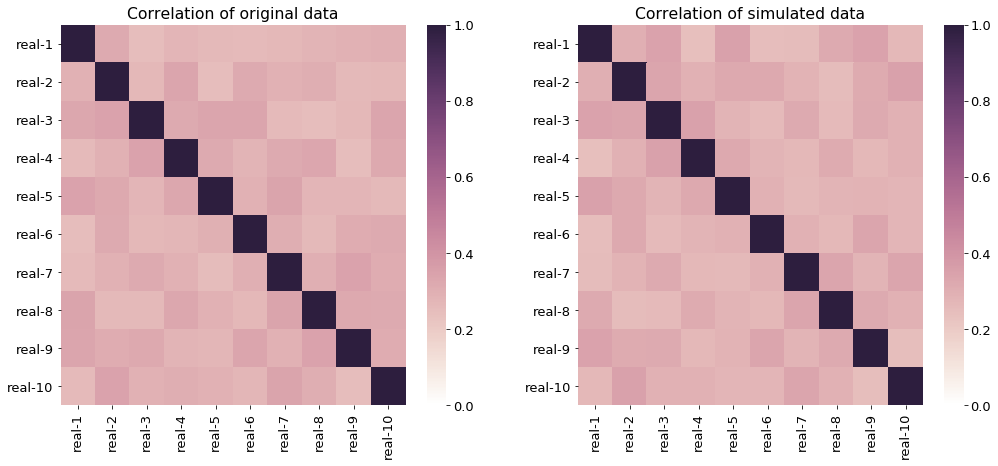

=========== Working for center: 0.4 ============


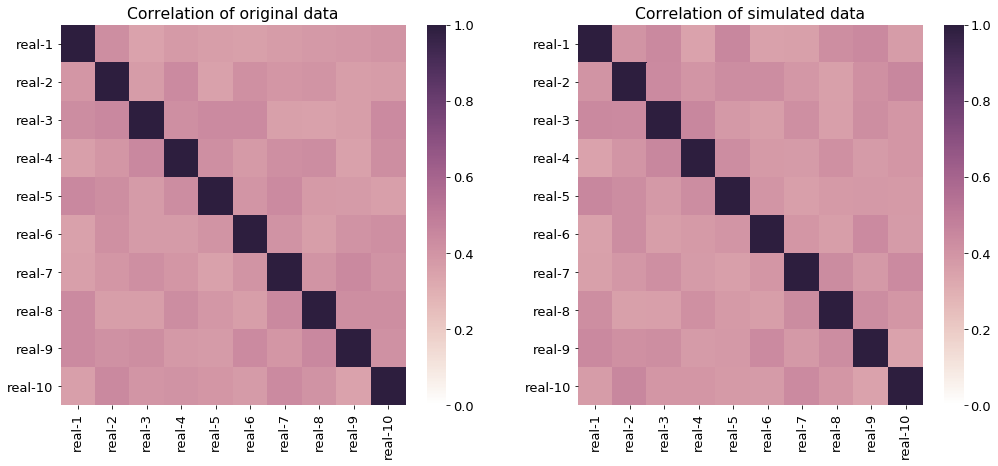

=========== Working for center: 0.5 ============


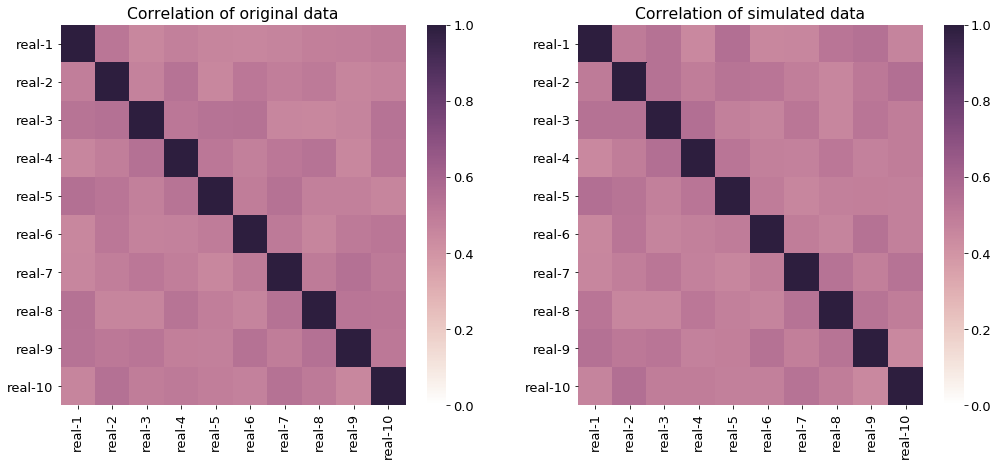

=========== Working for center: 0.6 ============


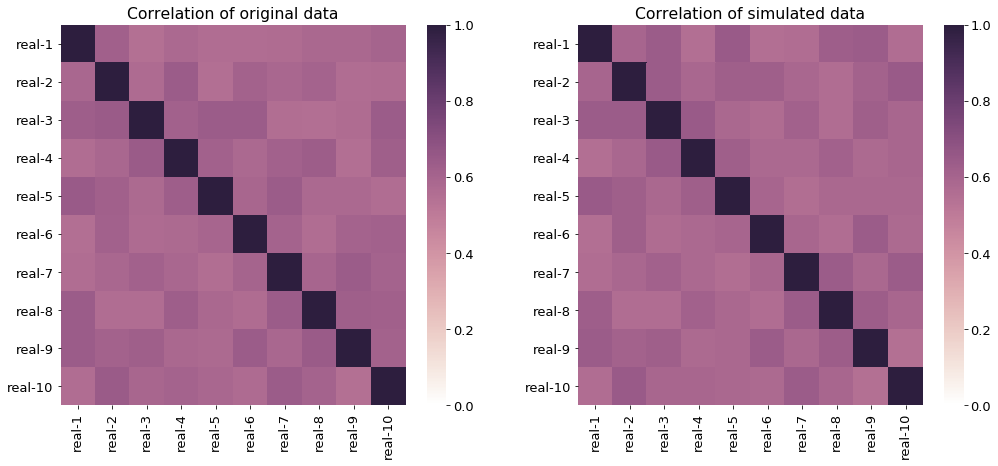

=========== Working for center: 0.7000000000000001 ============


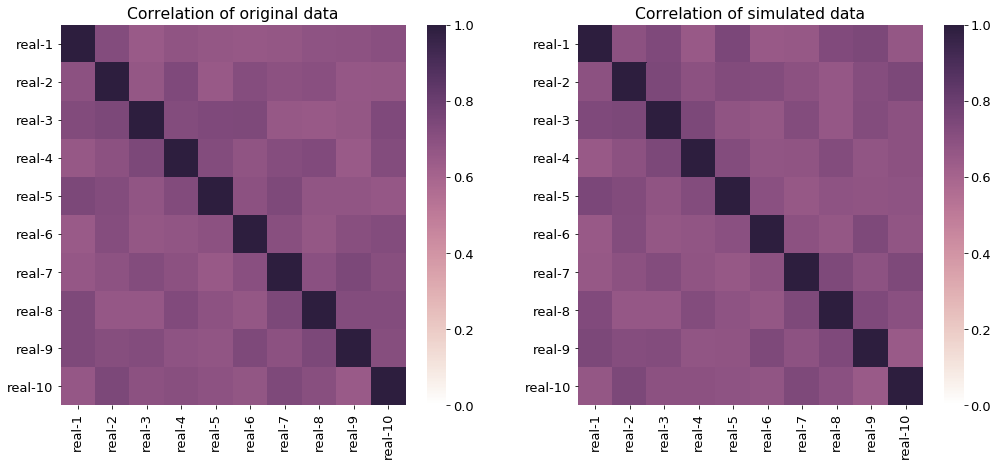

=========== Working for center: 0.8 ============


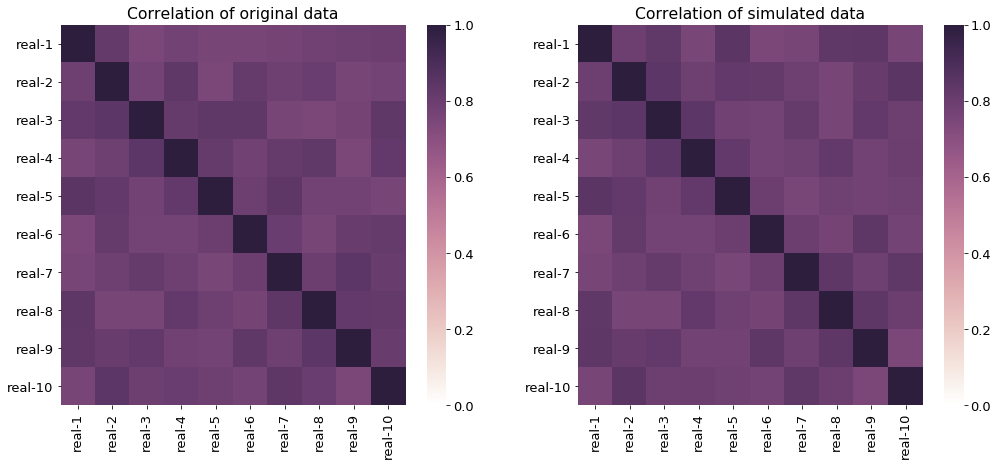

=========== Working for center: 0.9 ============


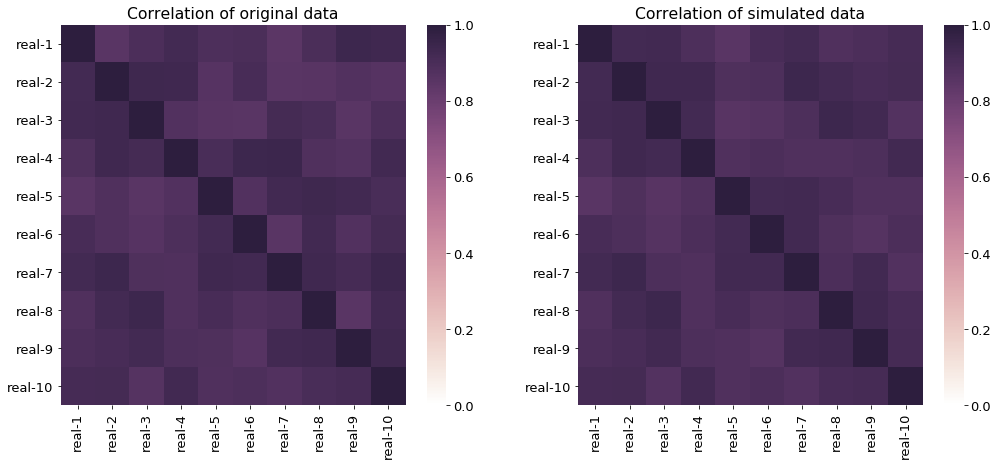

In [55]:
for i, center in enumerate(variation_centers):
    print("=========== Working for center: {} ============".format(center))
    
    min_, max_ = center - DELTA, center + DELTA
    C, seed = load_uniform_correlation_matrix(DIMENSION, min_=min_, max_=max_, max_iter=1000)
    X = simulate_multi_dimensional_real_data(NUM_SAMPLES, C, DIMENSION)
    X = pd.DataFrame(X, columns=['real-{}'.format(i + 1) for i in range(X.shape[1])])
    
    C_sim = X.corr(method='pearson')
    C = pd.DataFrame(C, columns=C_sim.columns, index=C_sim.columns)
    evaluate_simulated_data_by_correlation(C_sim, C)

    dataset[str(i + 1)] = {'center': center,'data': X, 'seed': seed, 'C_in': C, 'C_sim': C_sim}

In [56]:
save_synthetic_dataset(dataset, name='additional_dataset_1')

### 10D Real: Varying `c_t`: correlation(imp, target) and `c_s`: correlation(QIDs, sensitive)

In [60]:
dataset = defaultdict(dict)

DIMENSION = 10
NUM_SAMPLES = 5000

In [70]:
corr_tagret_pool = np.linspace(0.1, 0.9, 9)
corr_sensitive_pool = np.linspace(0.1, 0.9, 9)

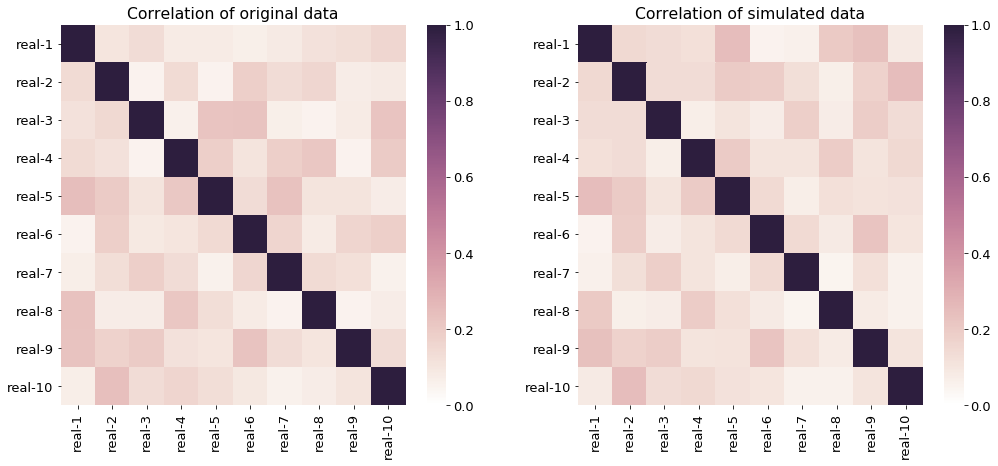

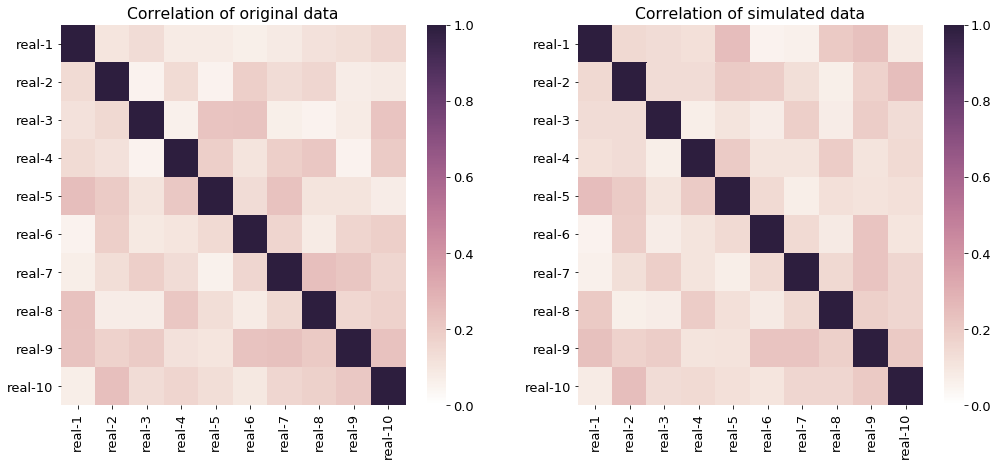

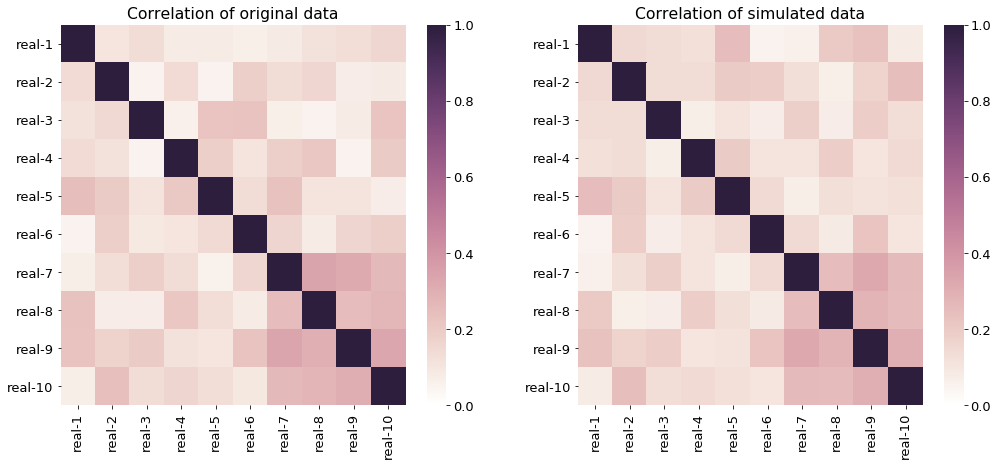

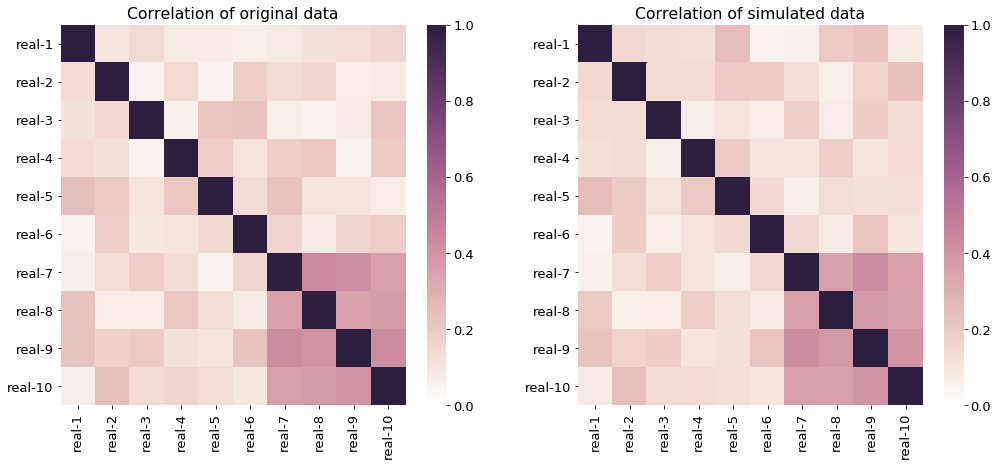

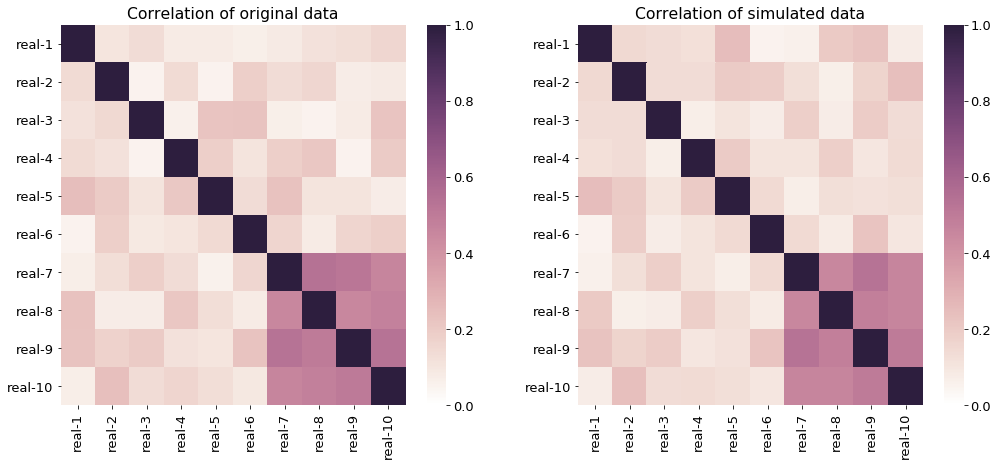

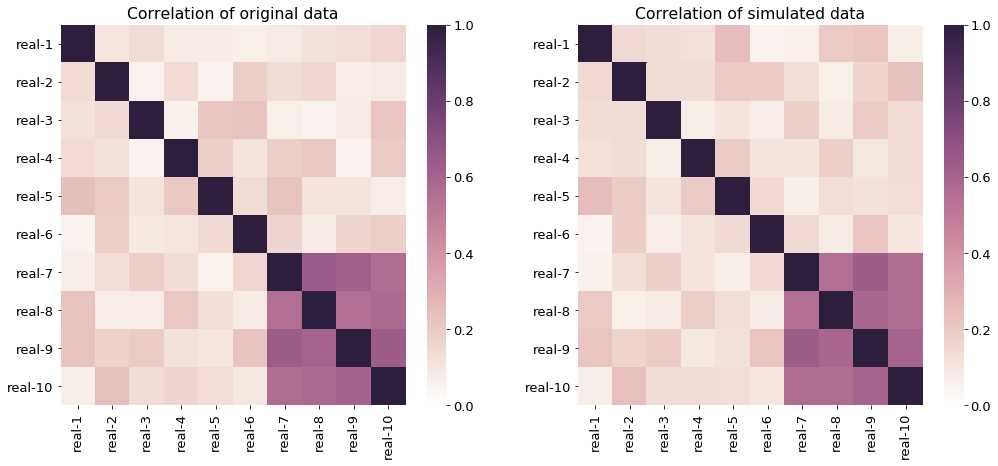

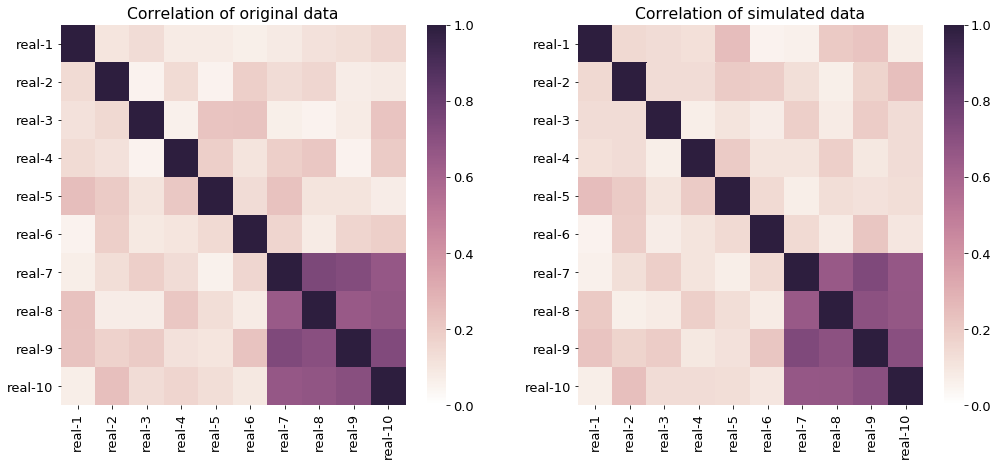

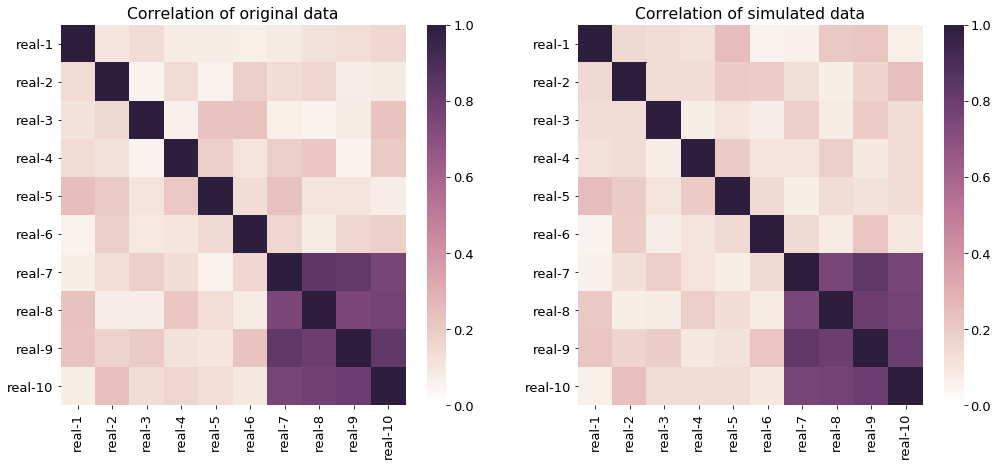

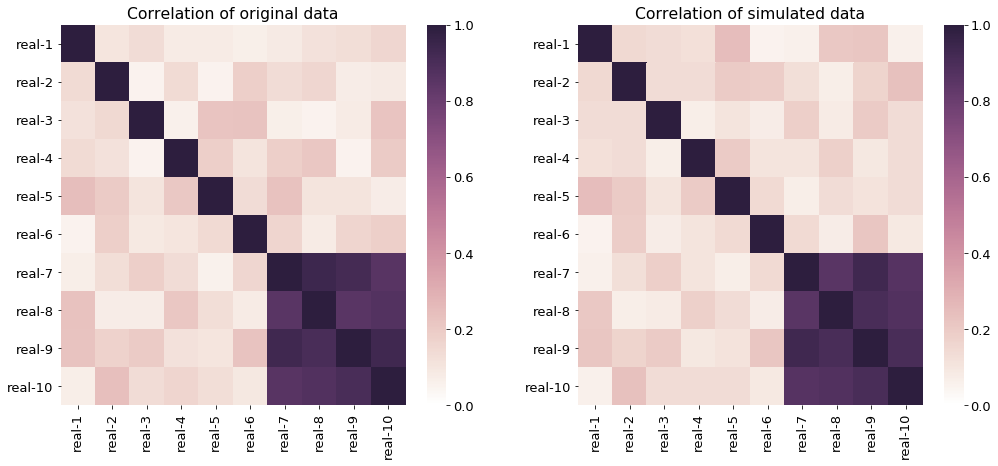

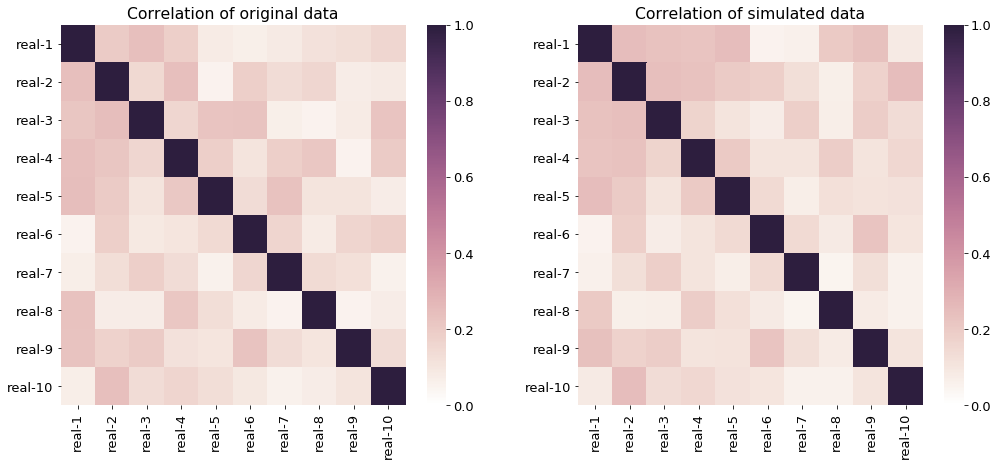

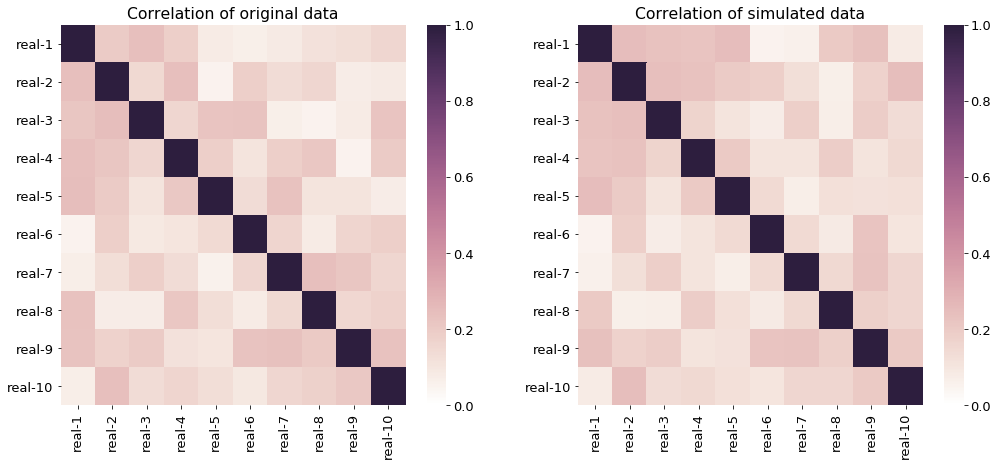

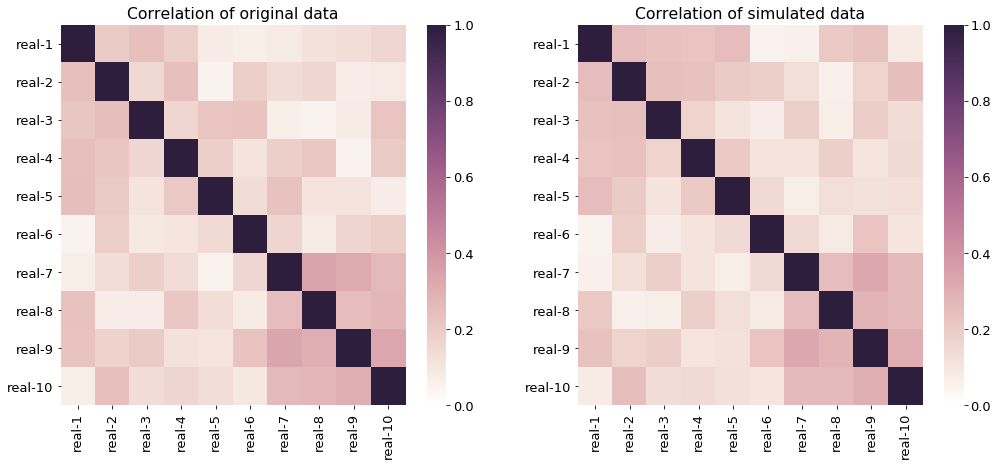

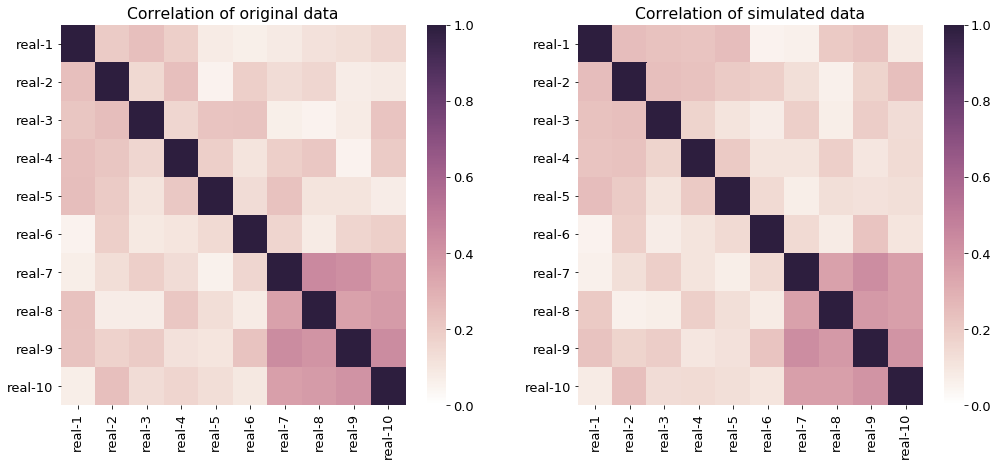

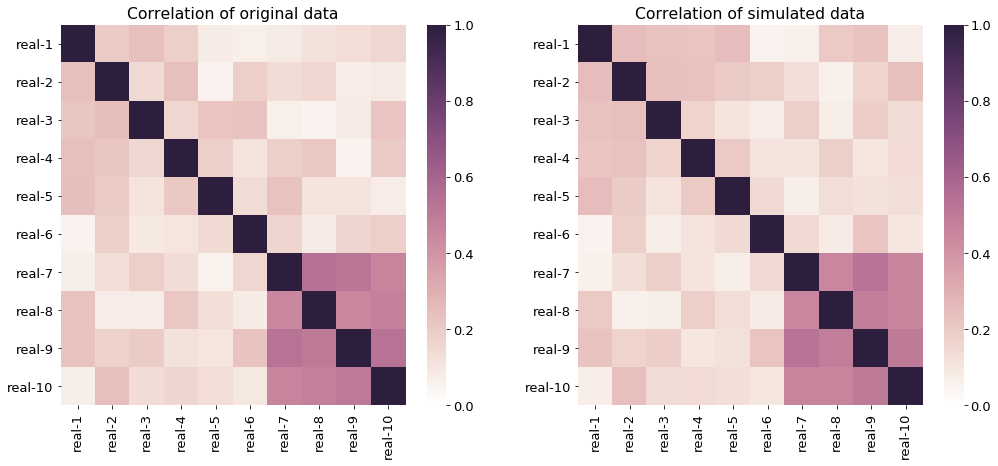

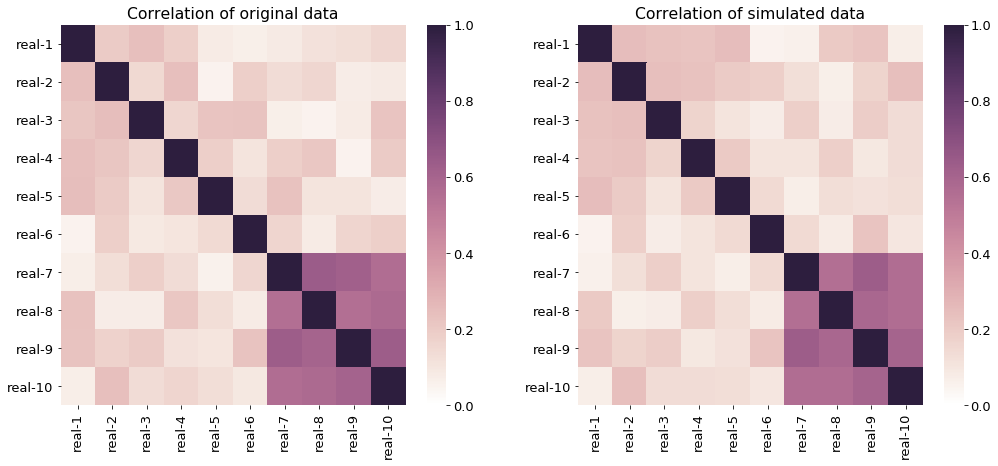

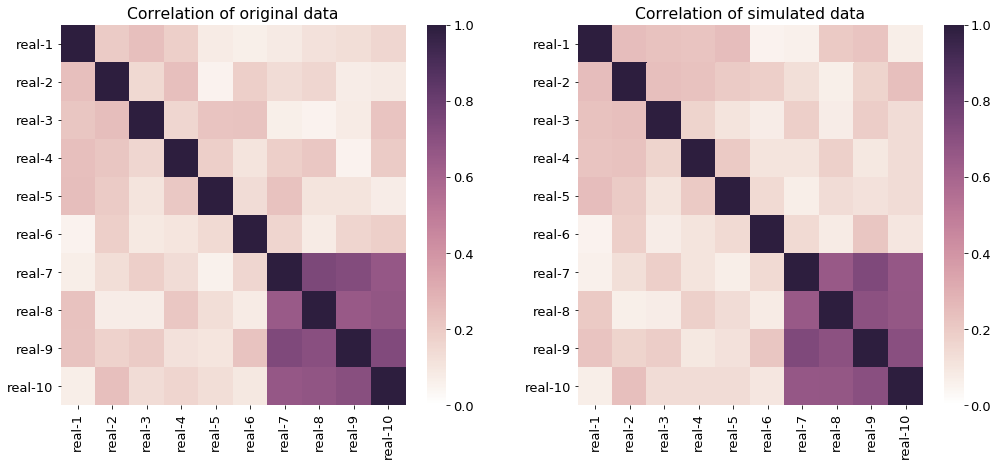

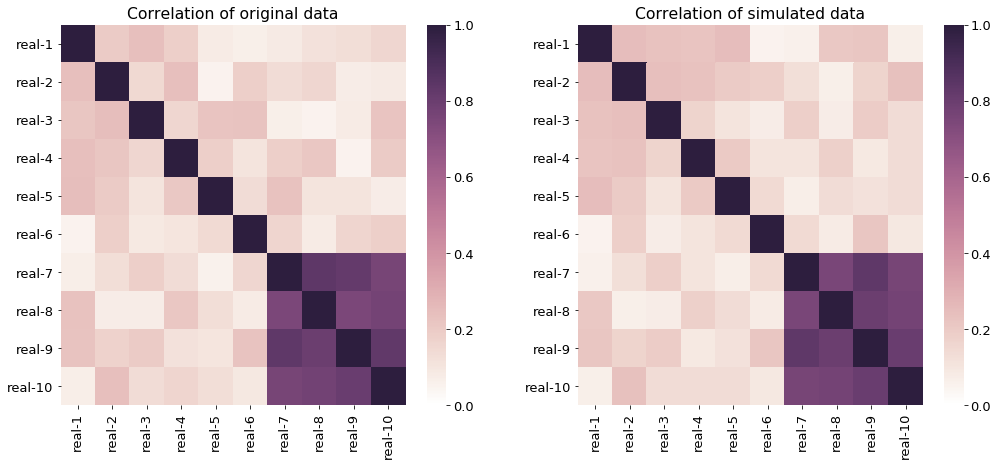

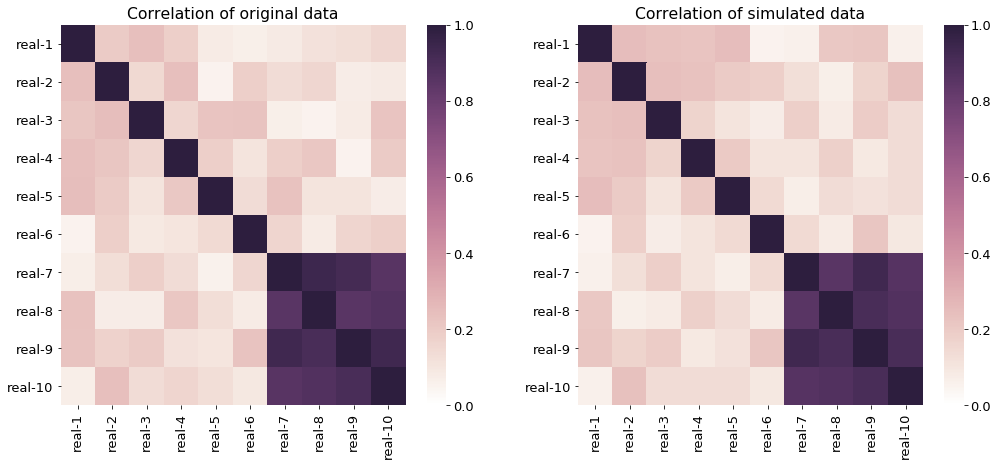

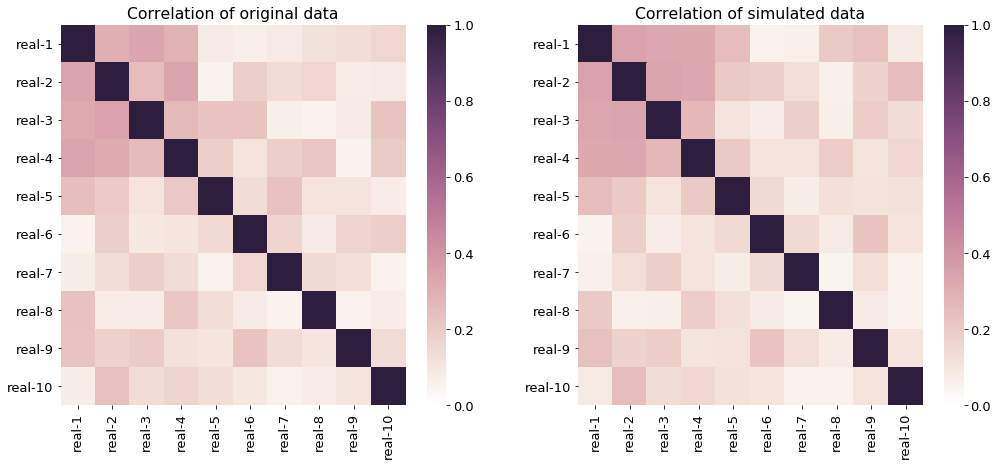

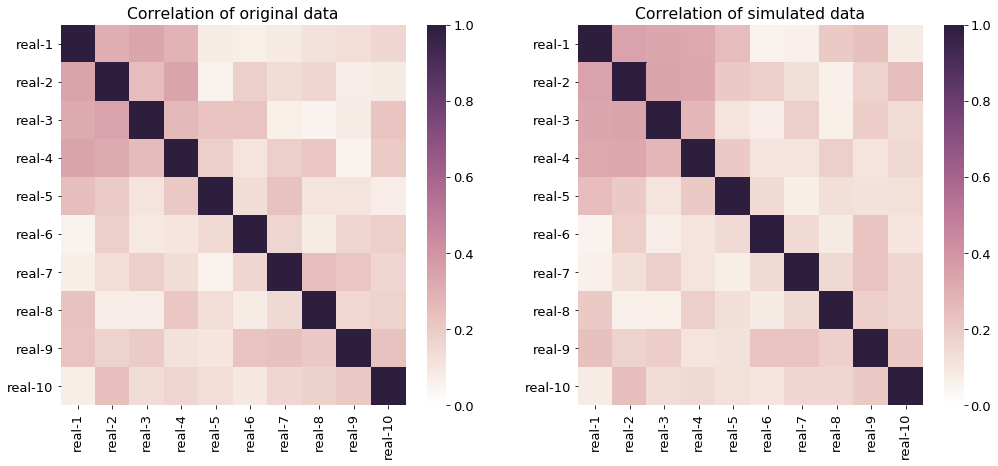

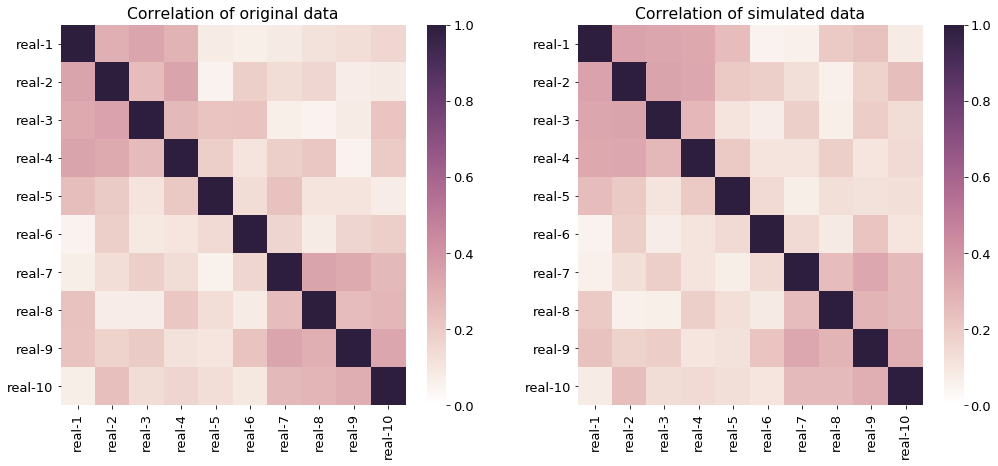

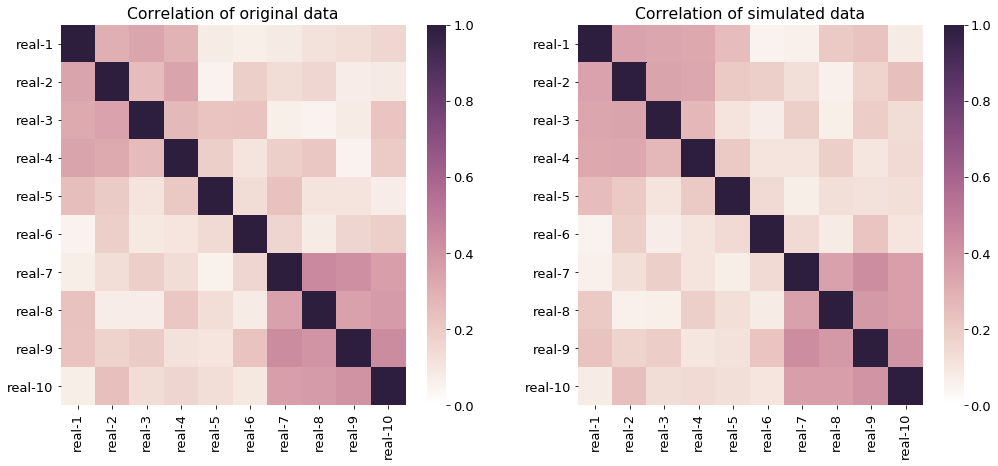

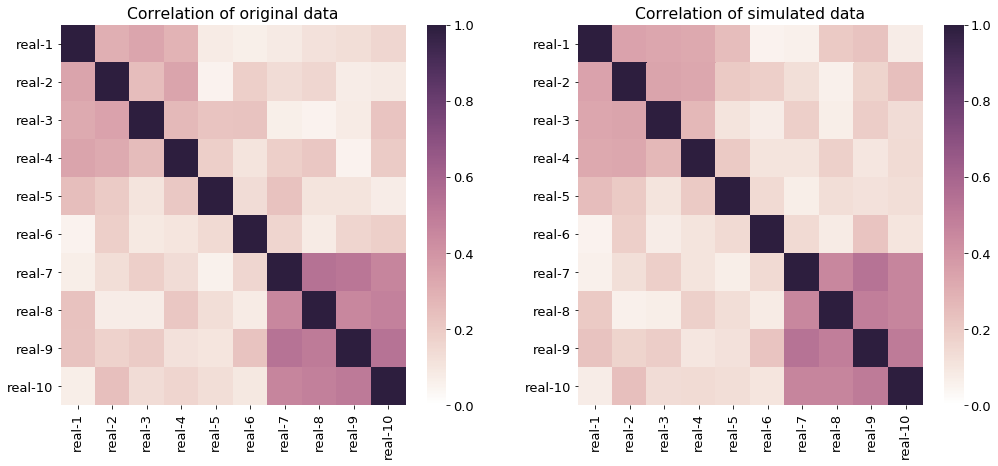

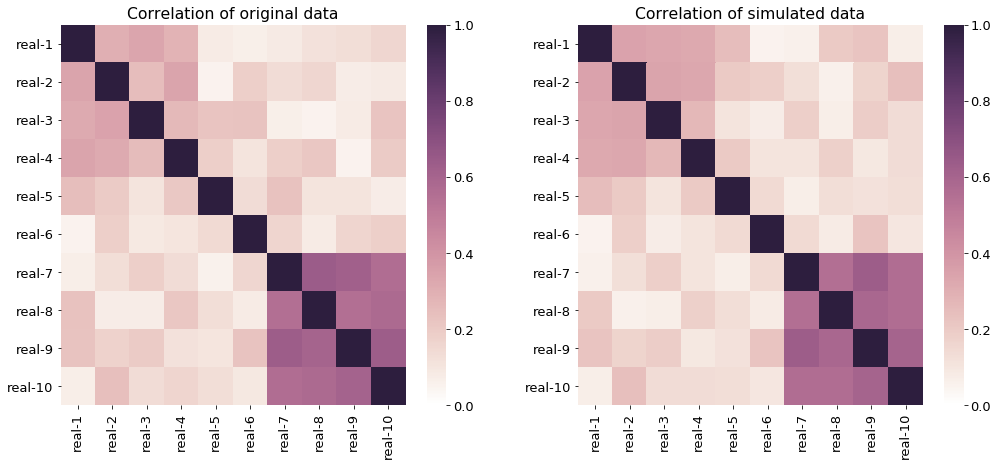

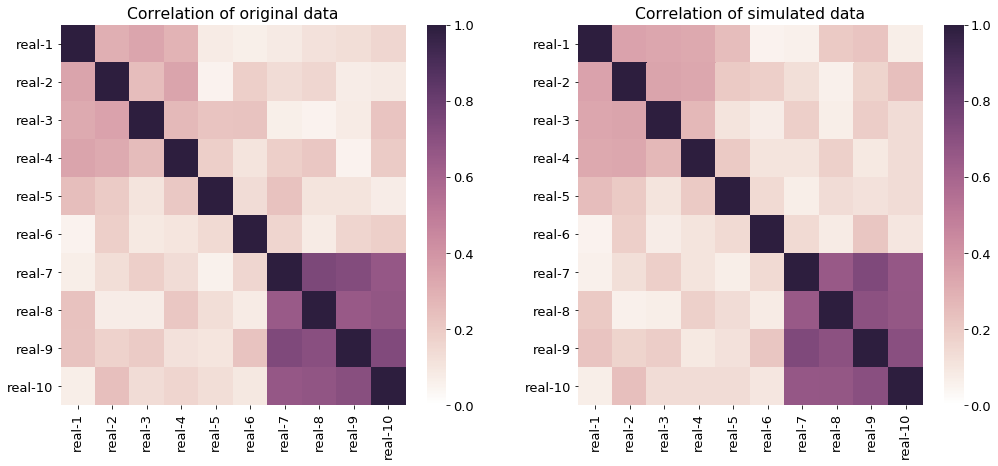

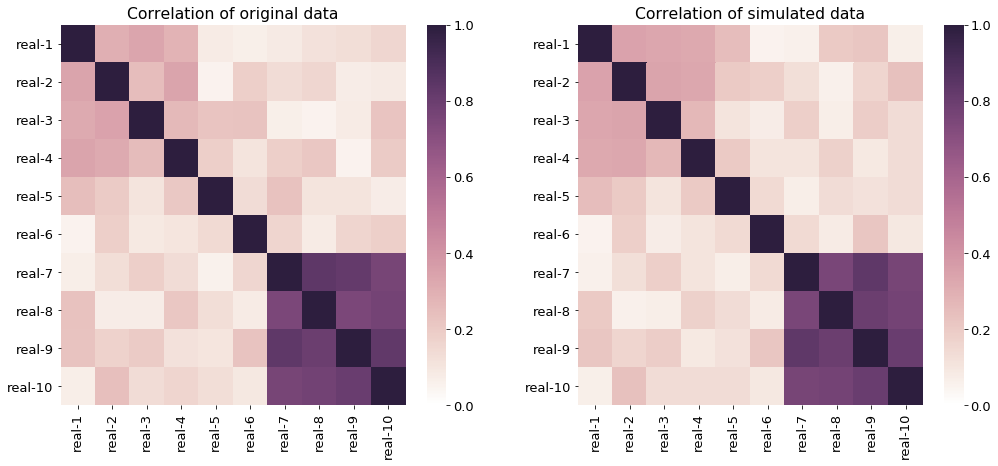

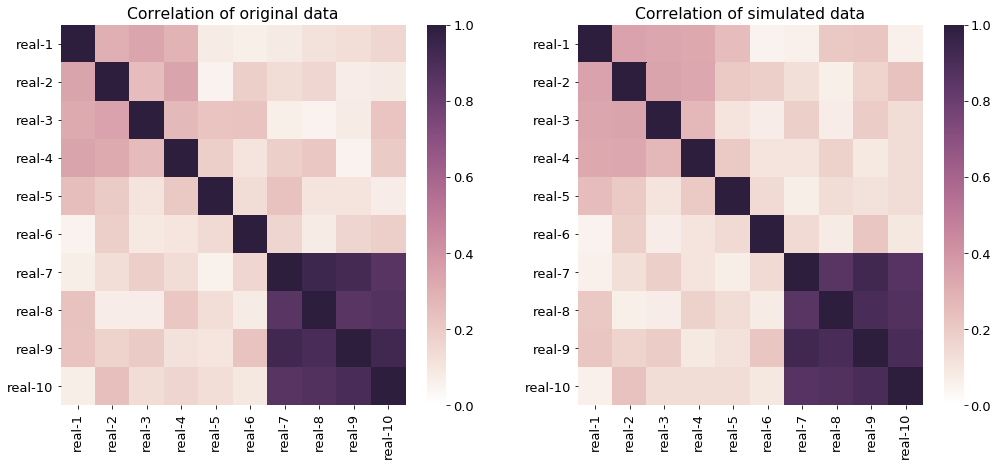

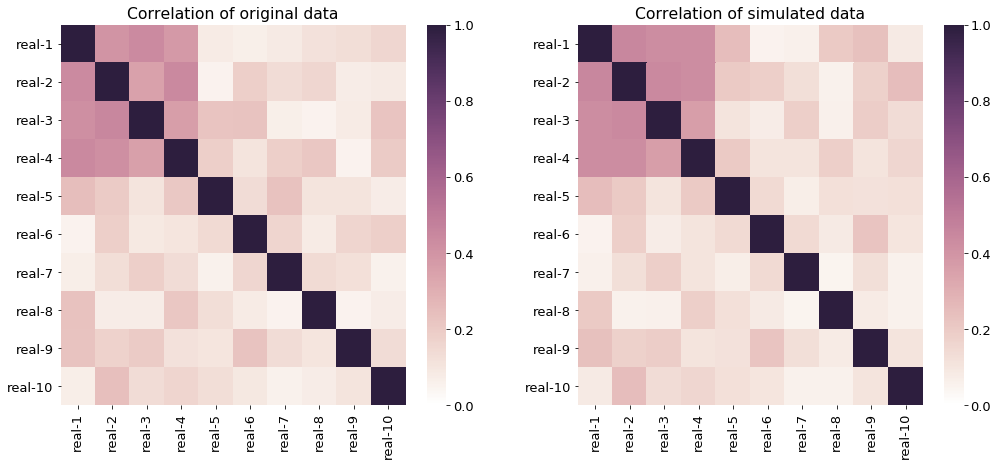

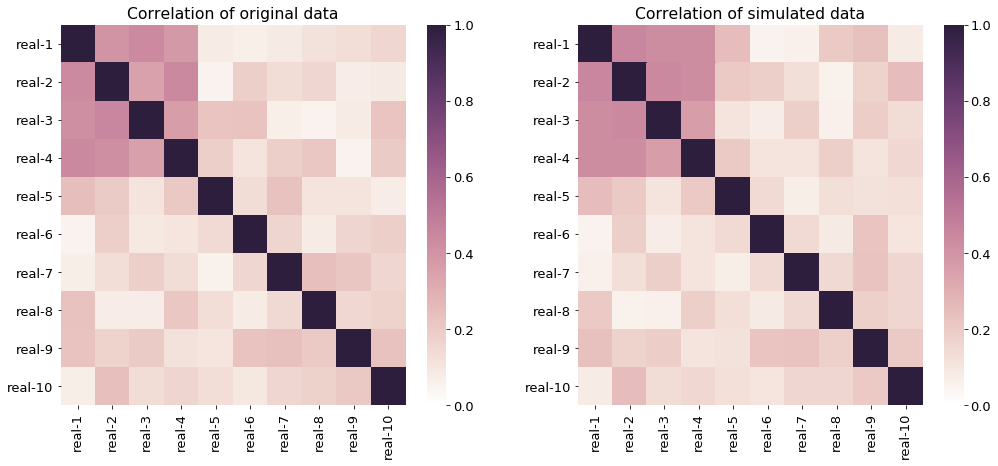

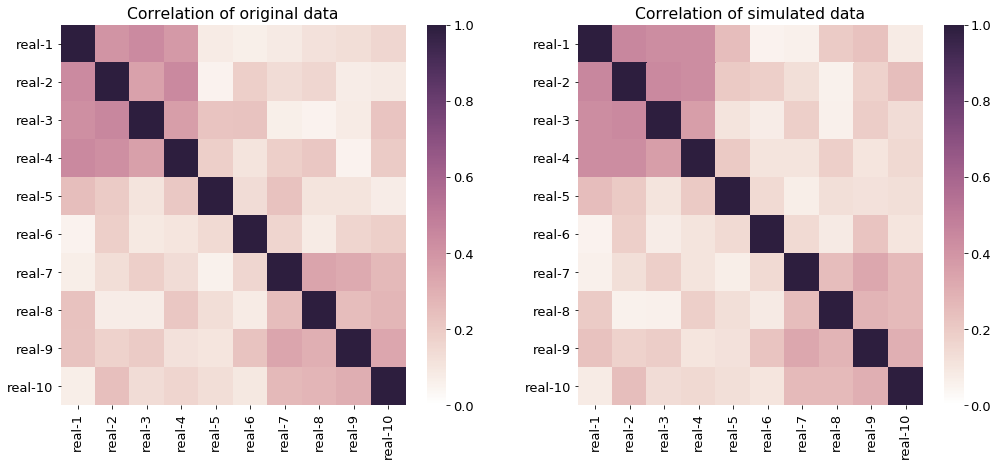

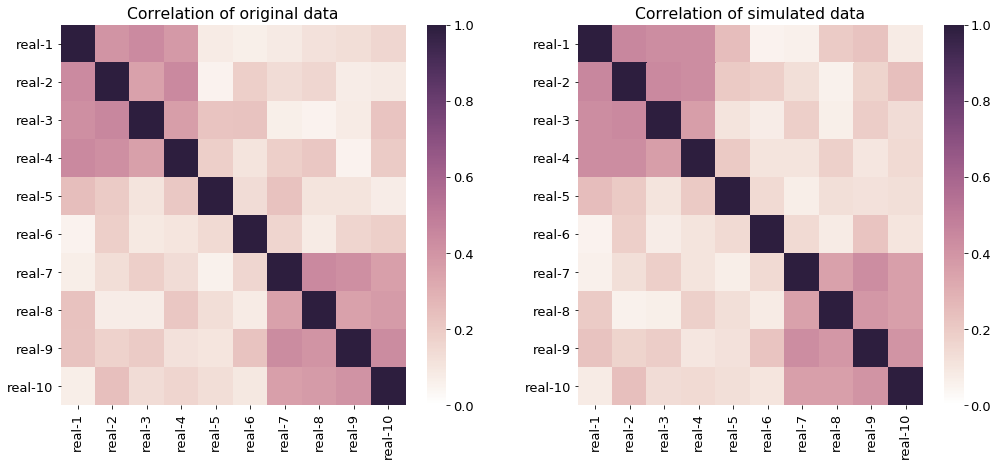

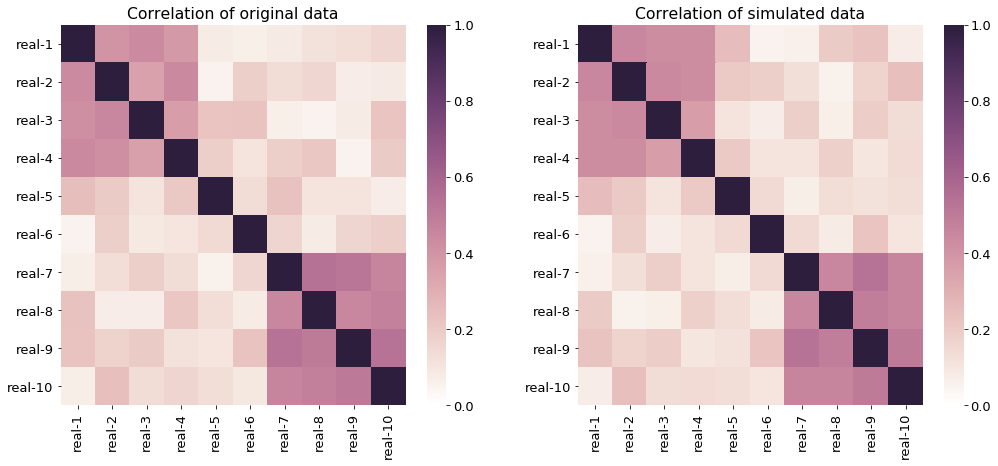

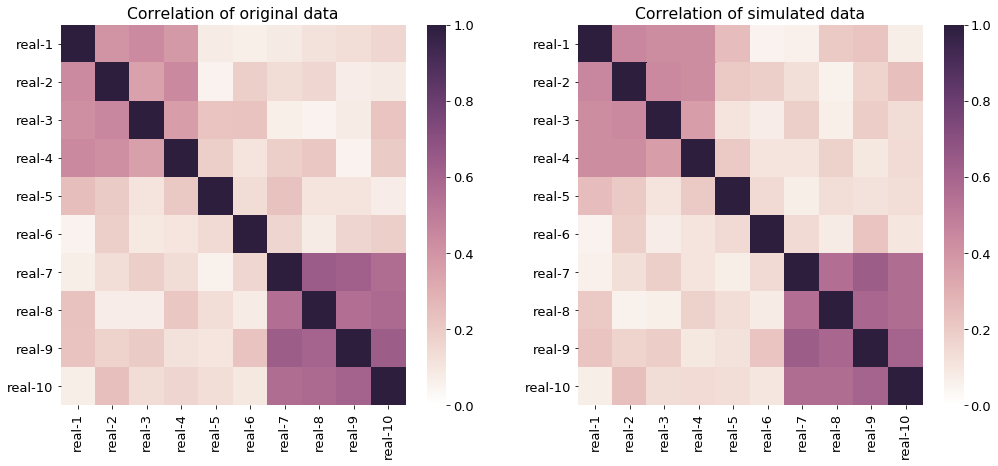

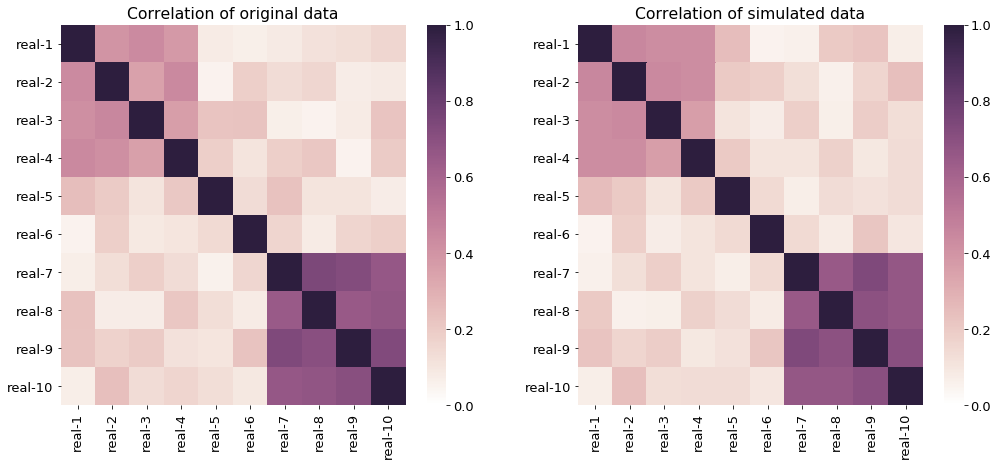

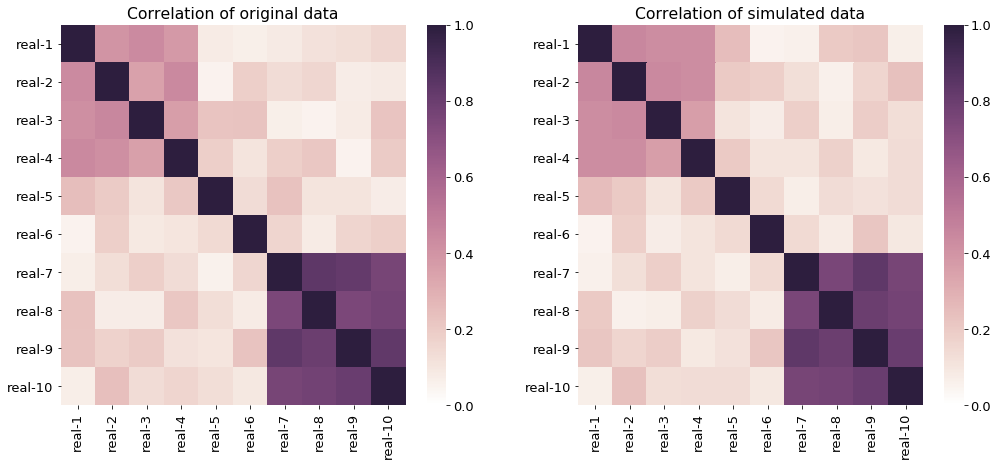

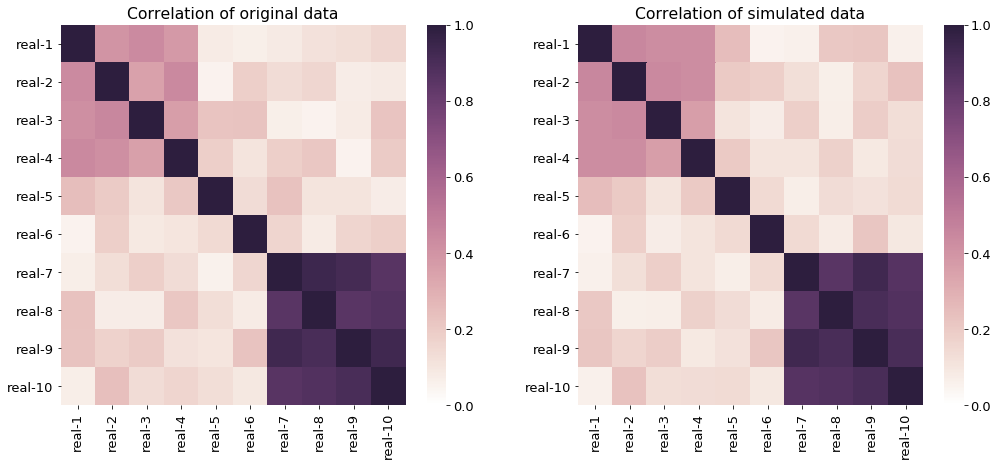

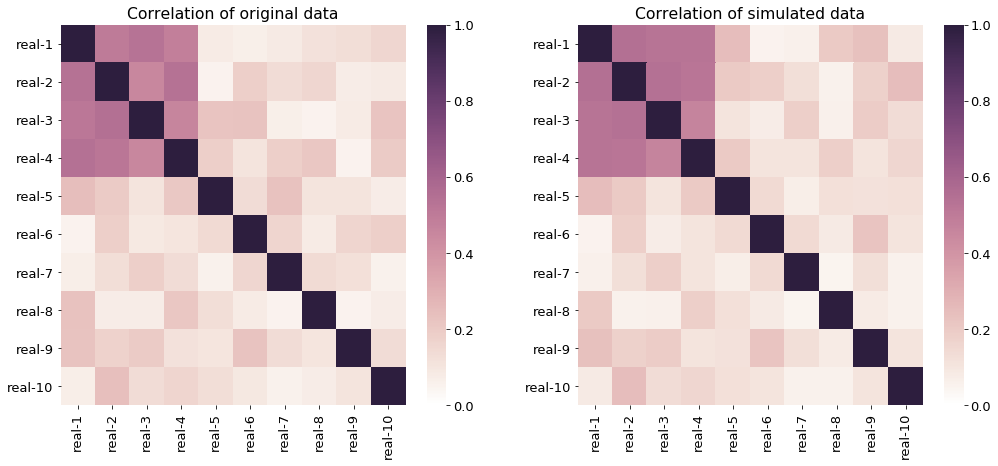

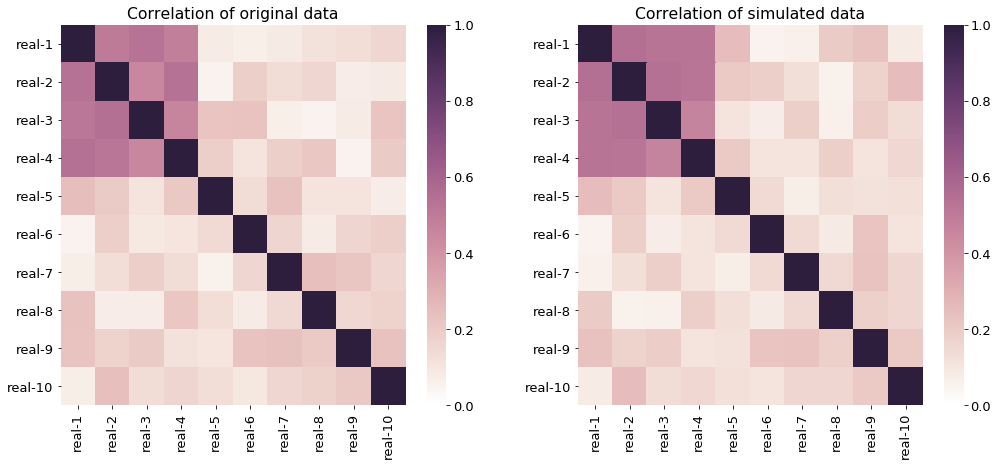

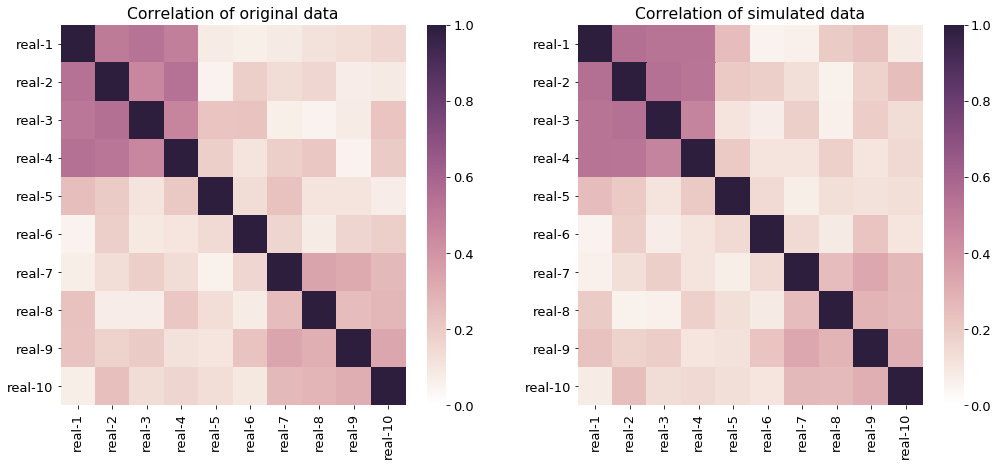

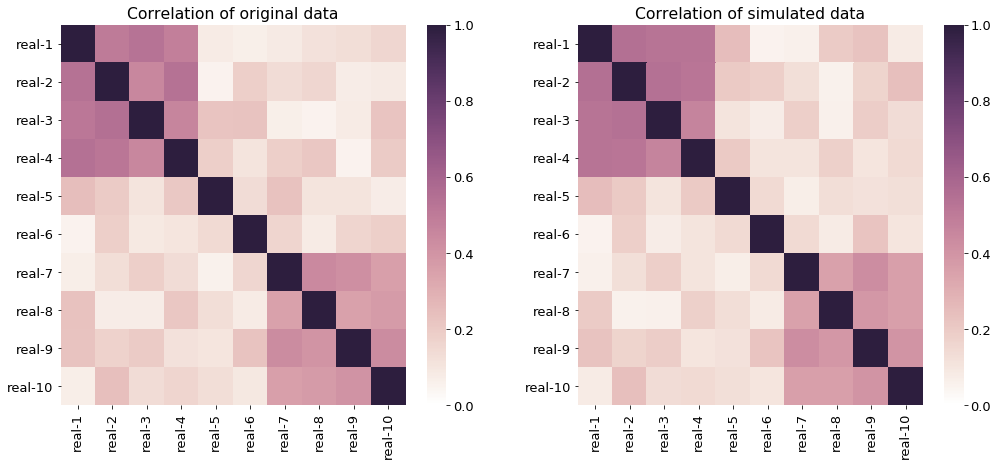

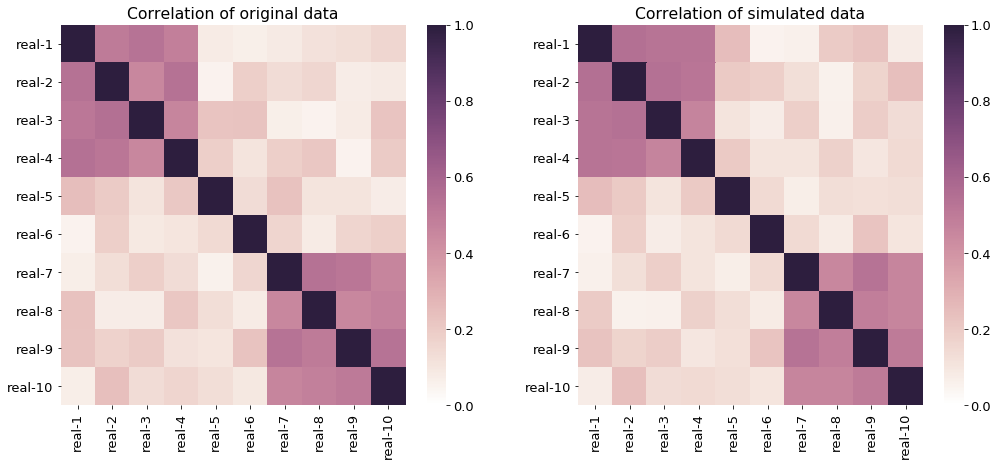

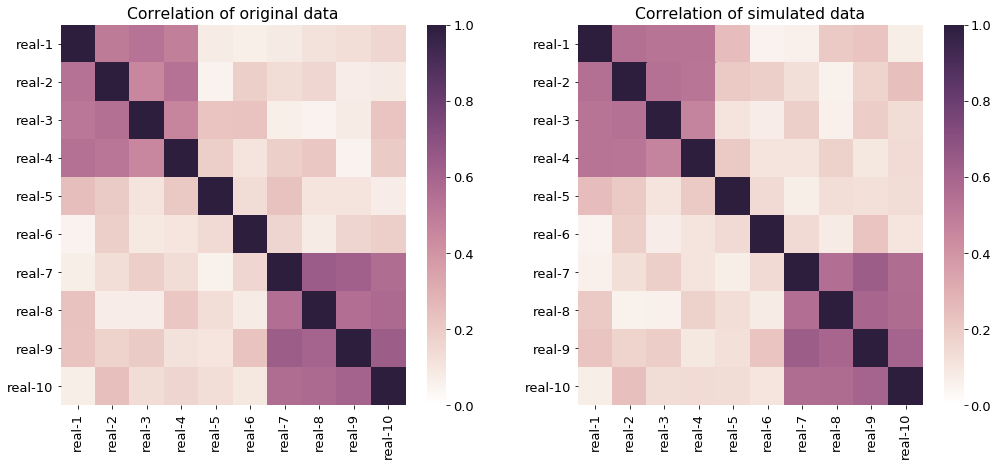

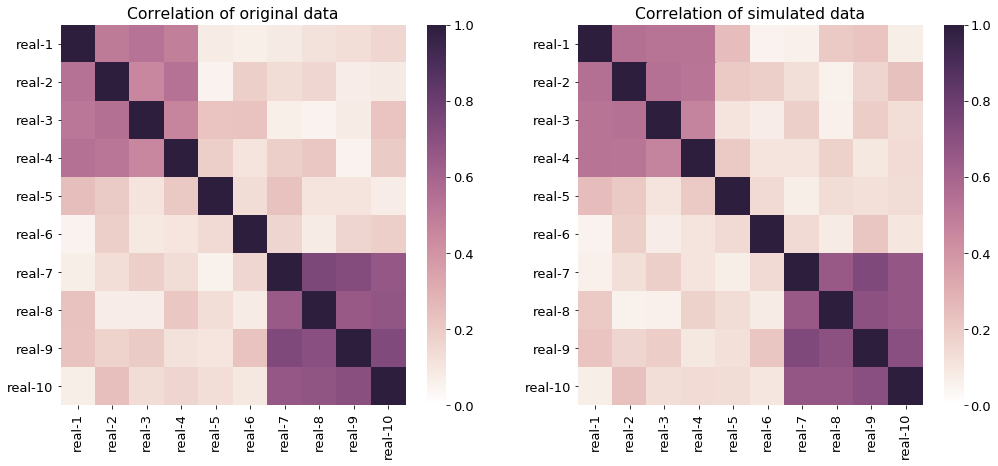

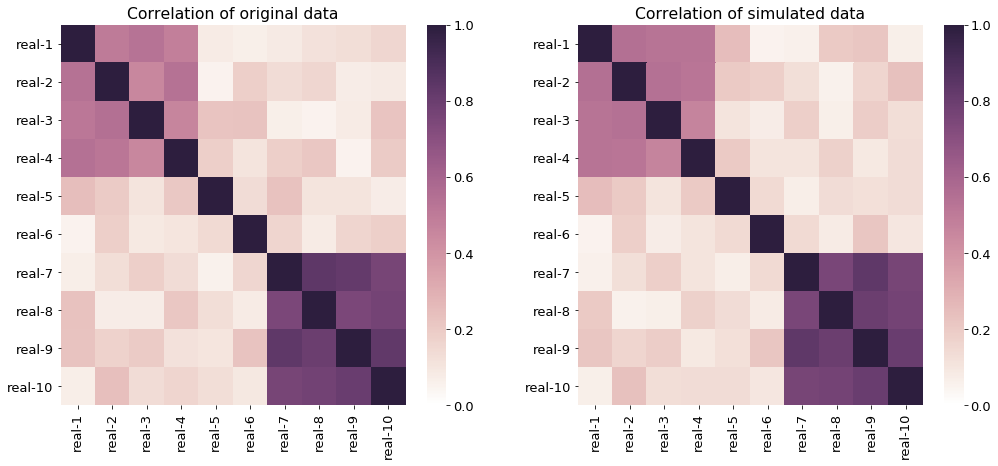

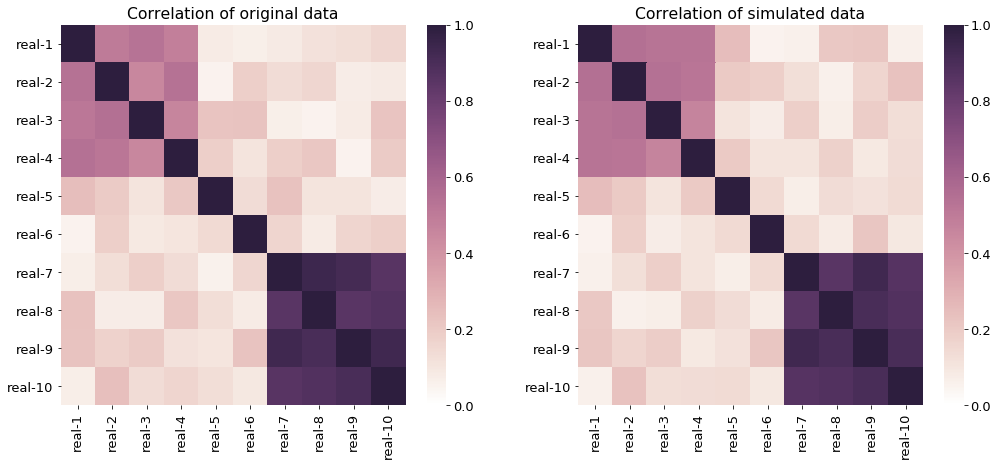

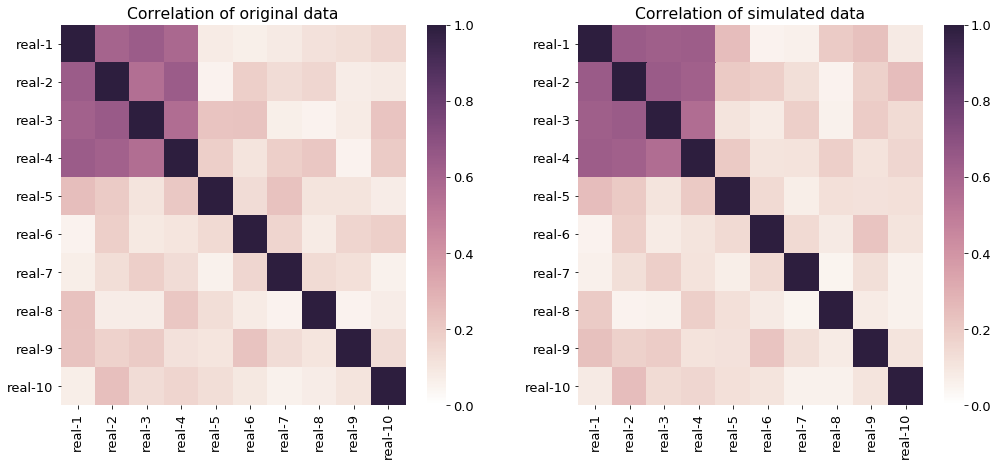

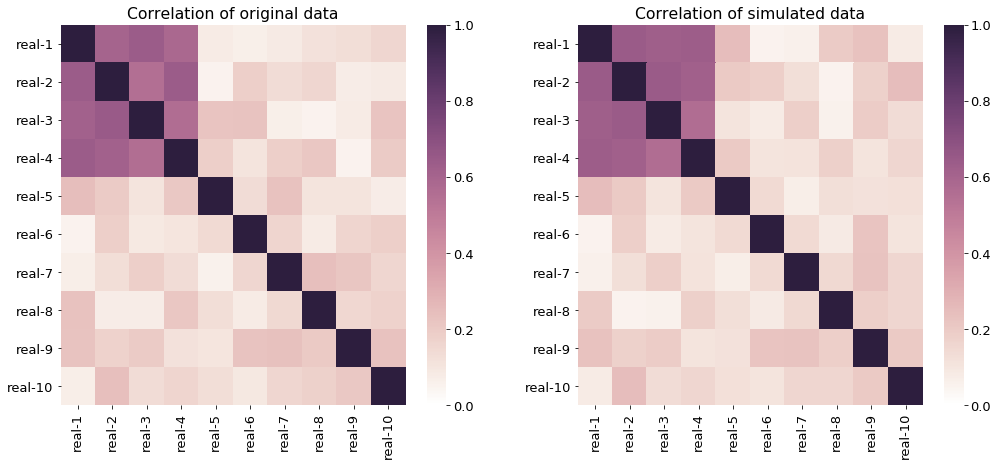

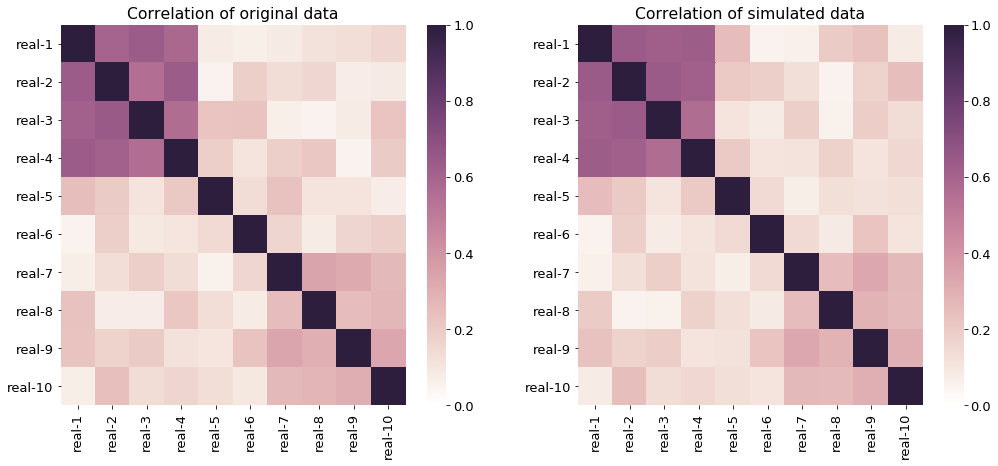

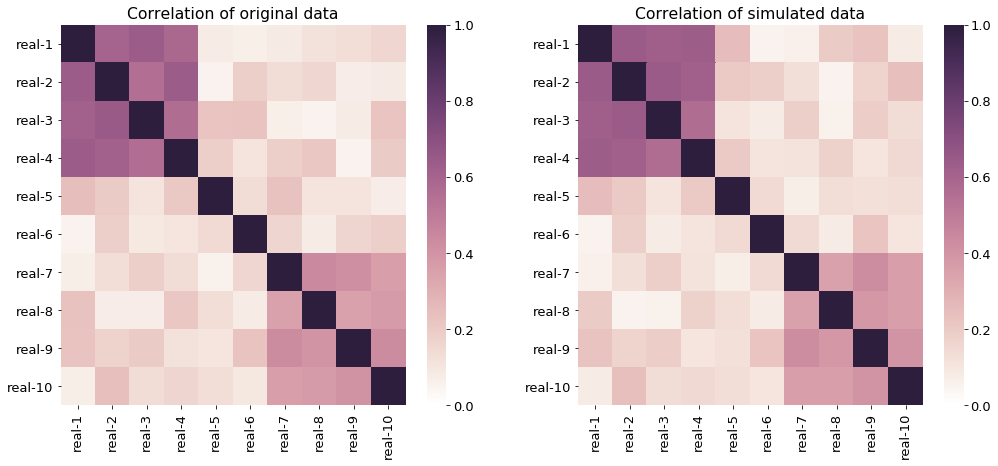

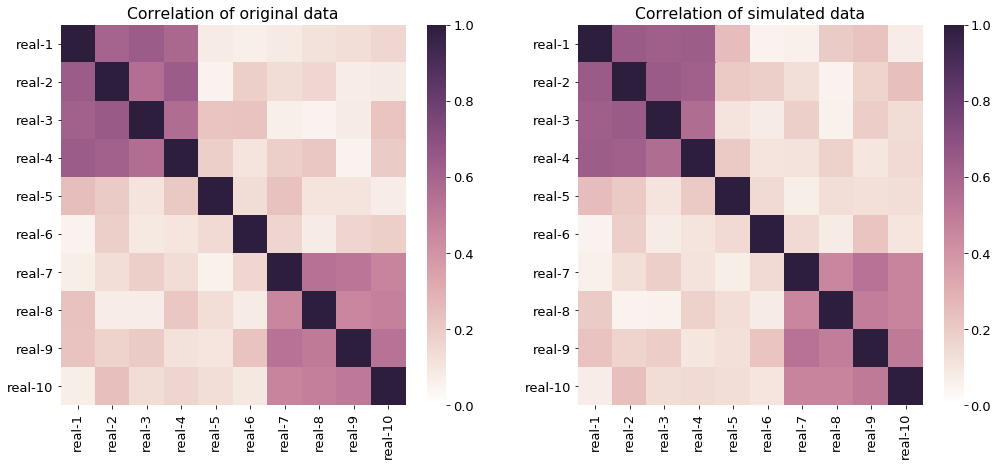

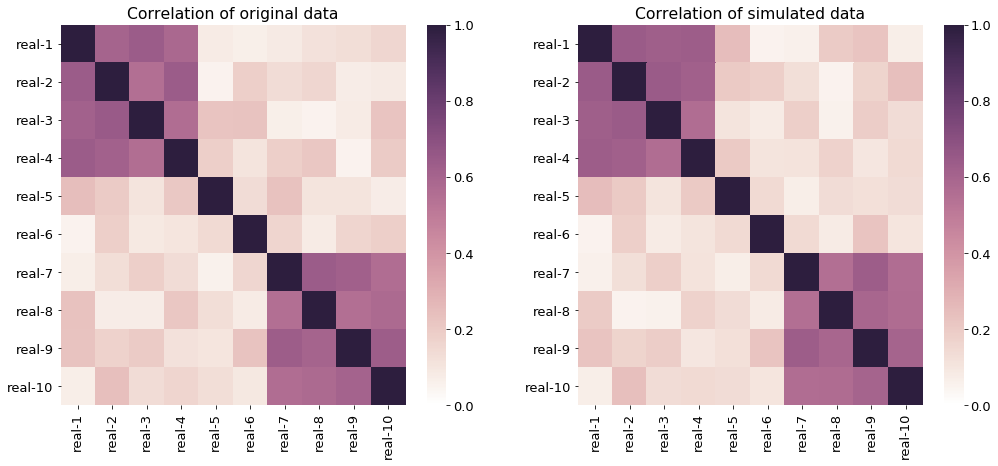

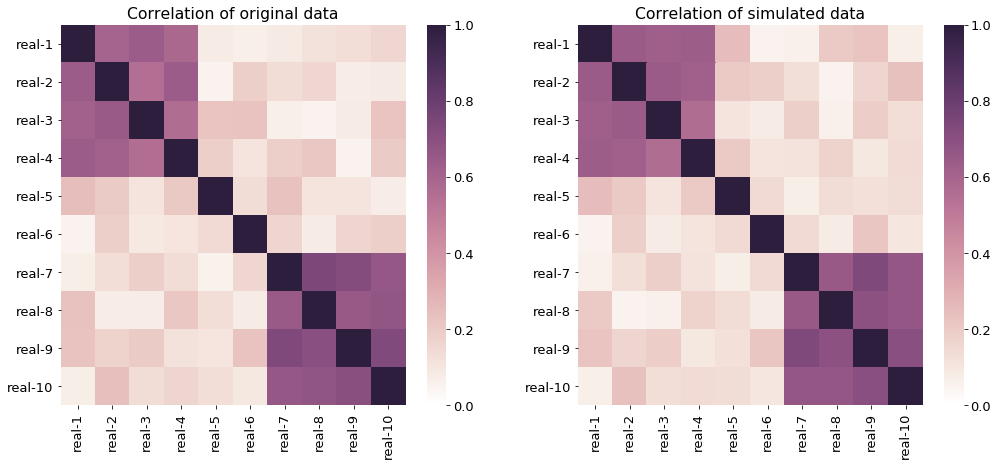

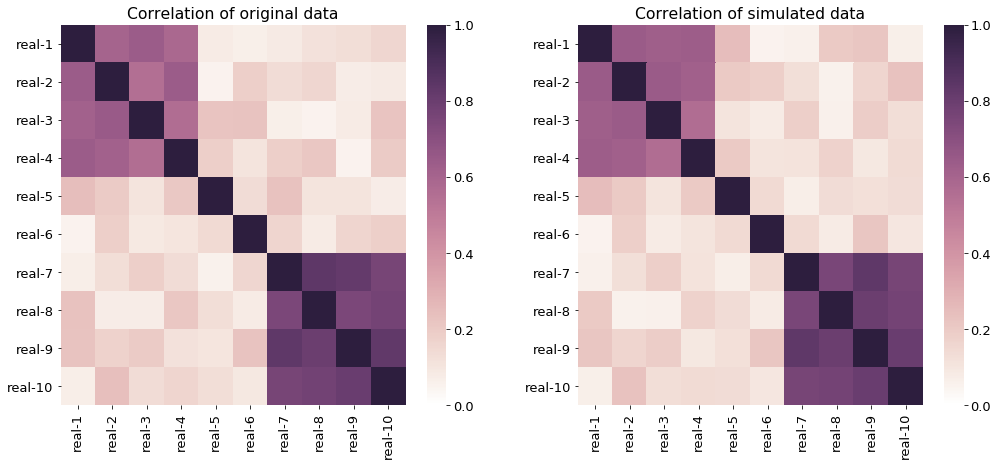

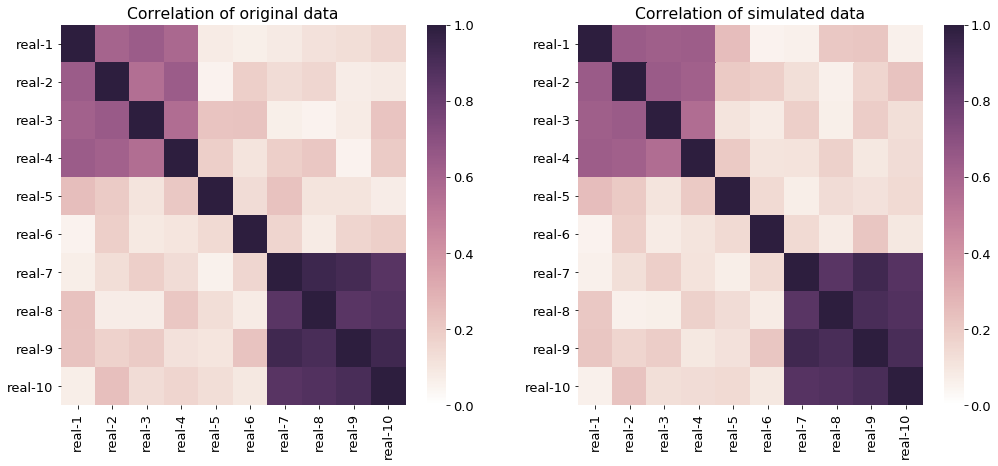

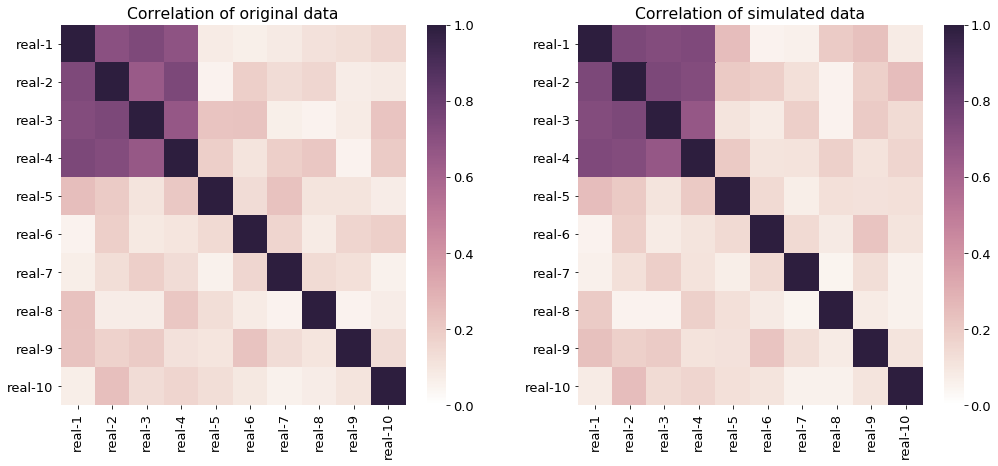

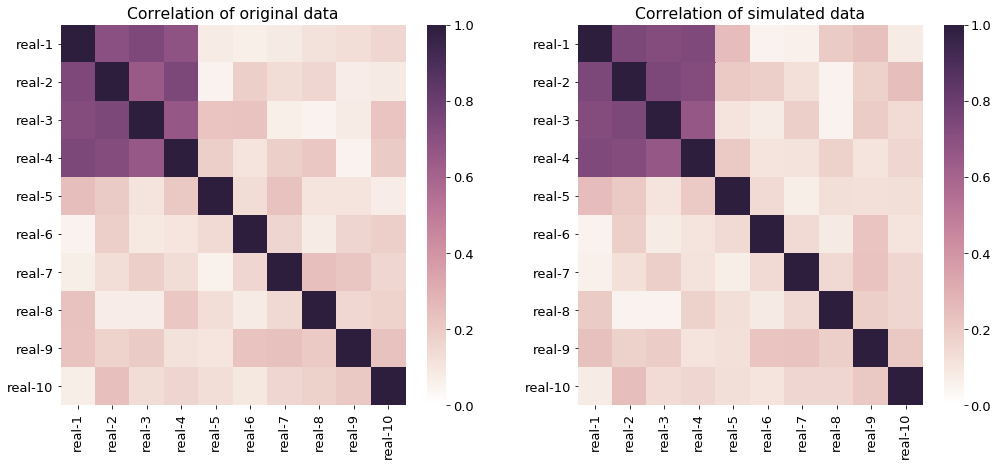

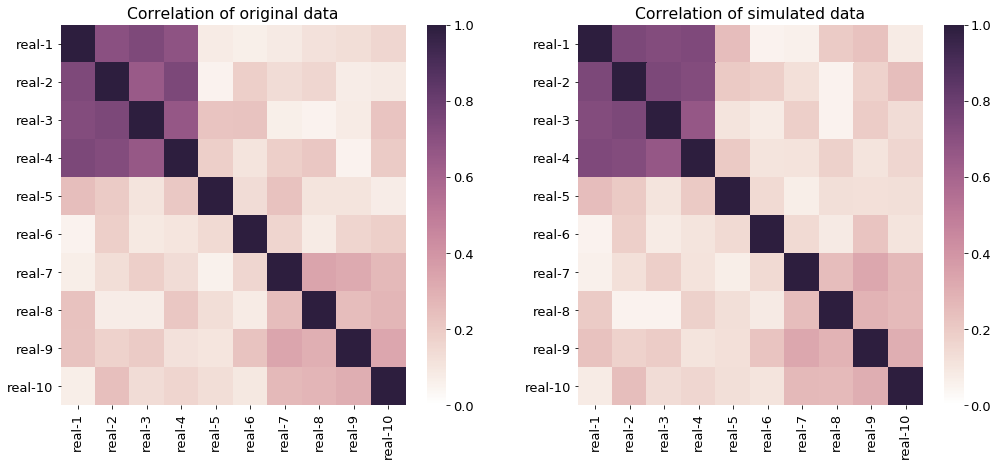

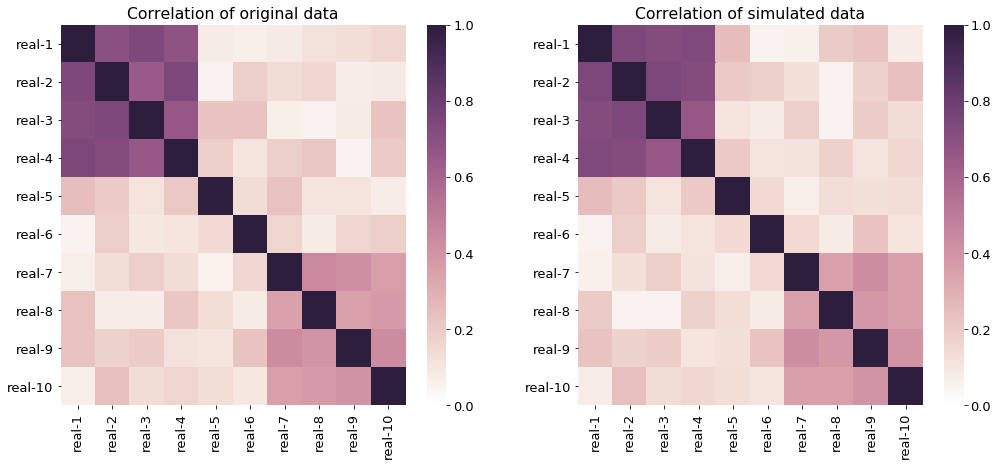

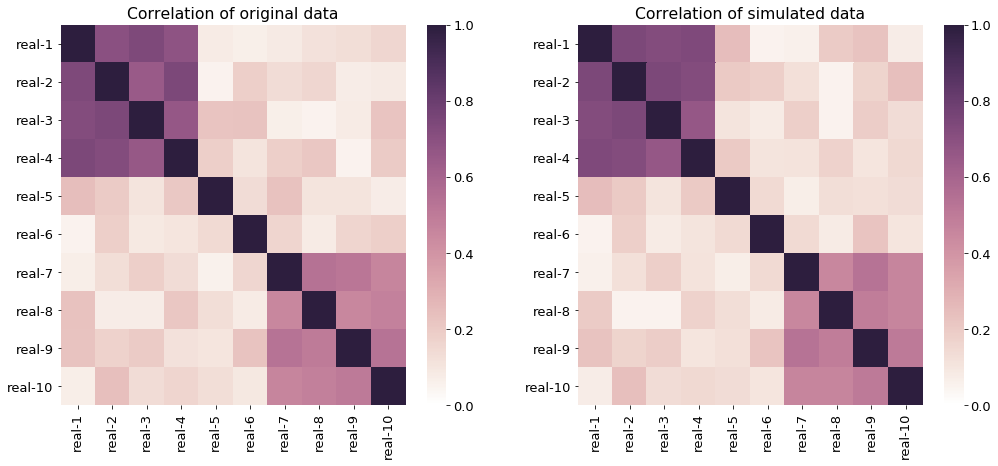

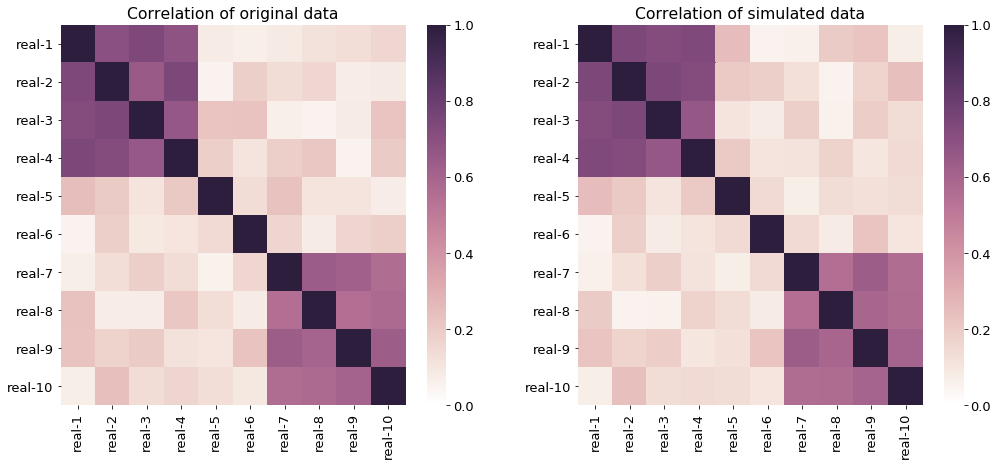

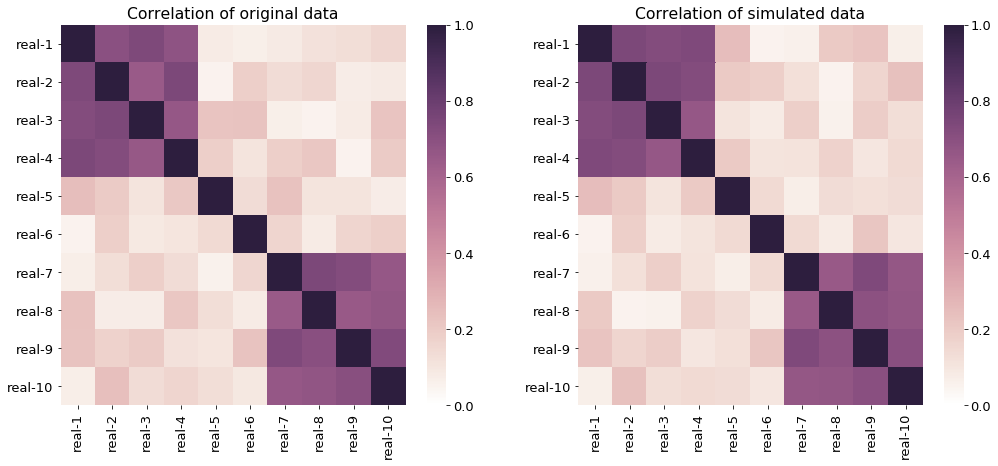

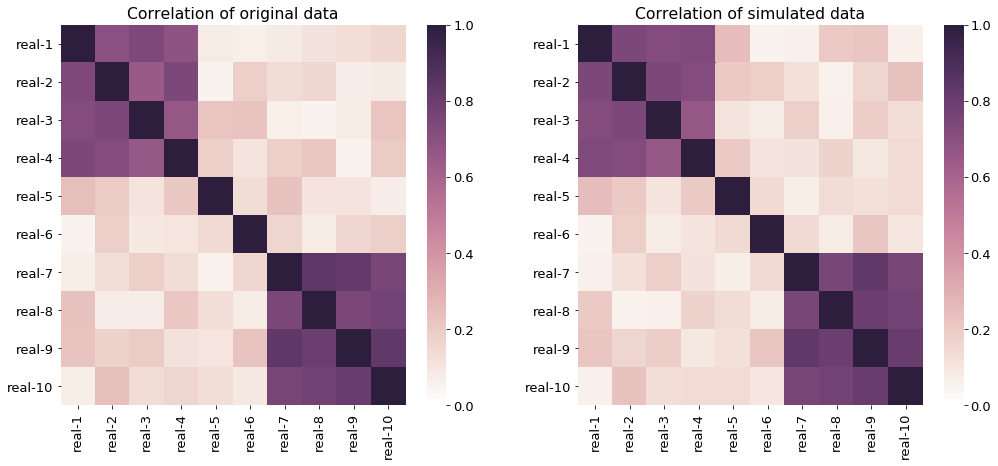

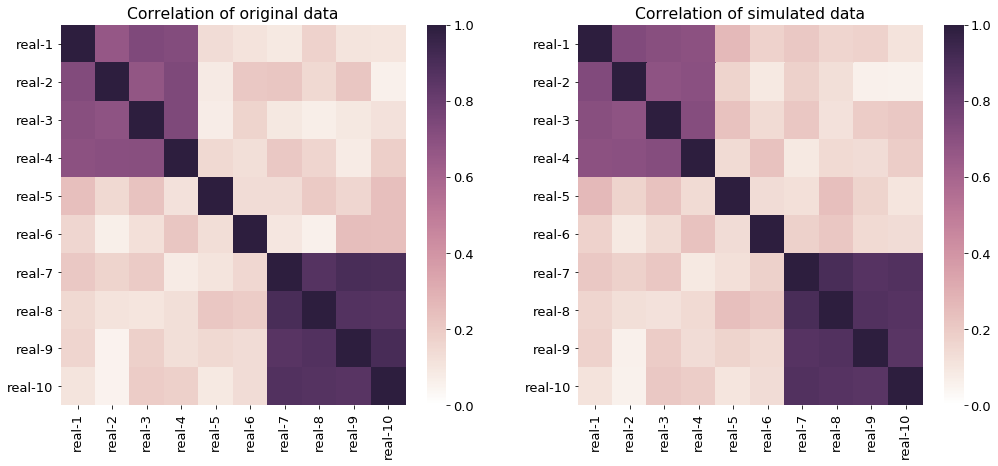

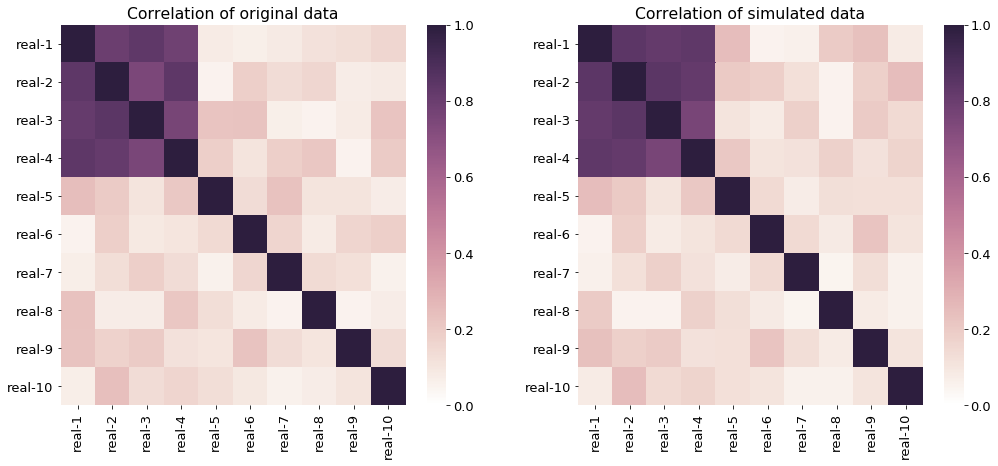

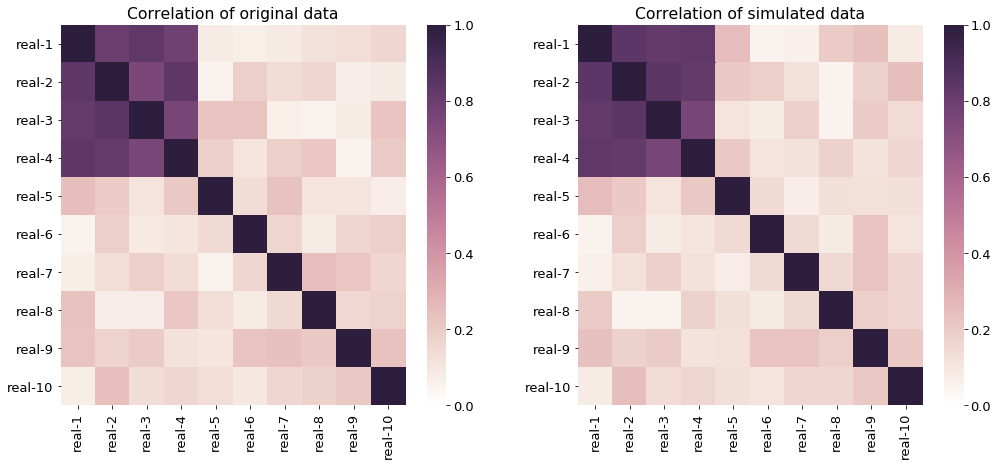

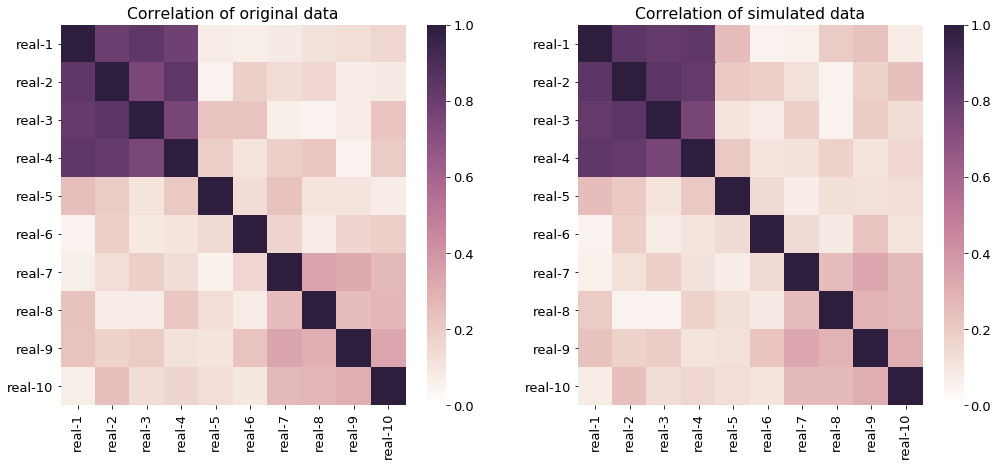

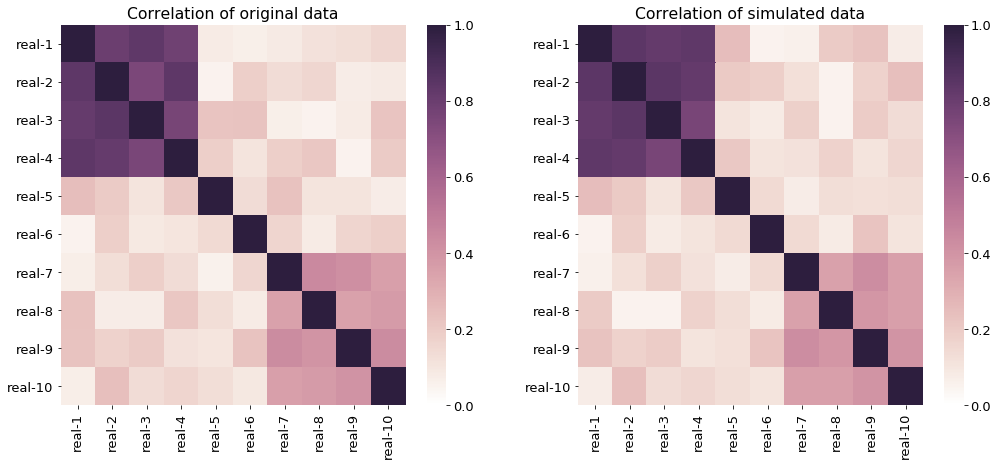

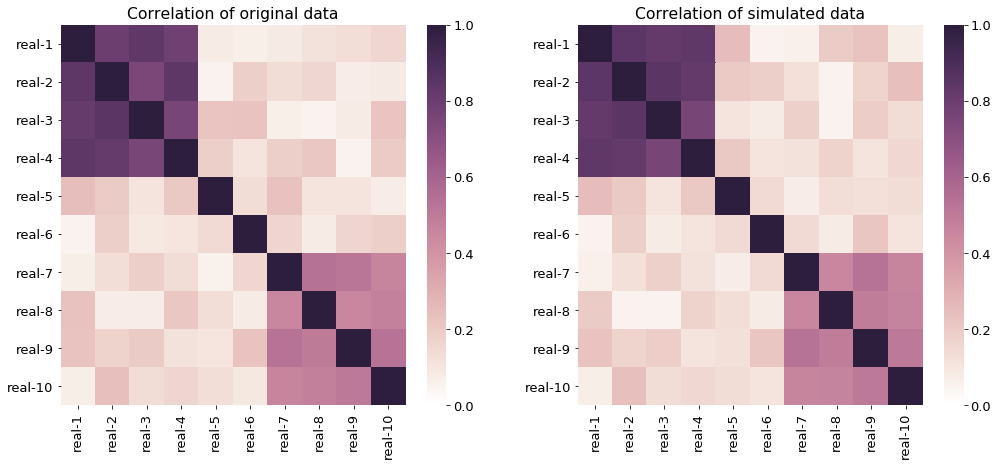

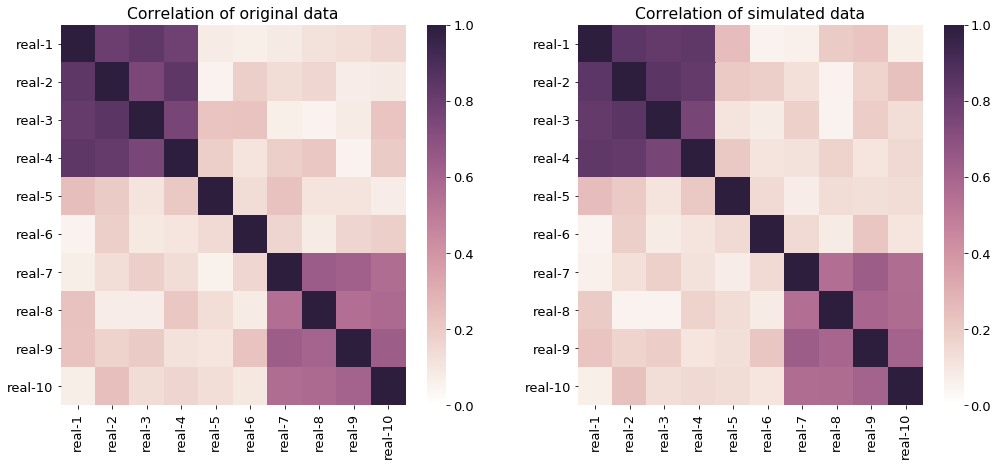

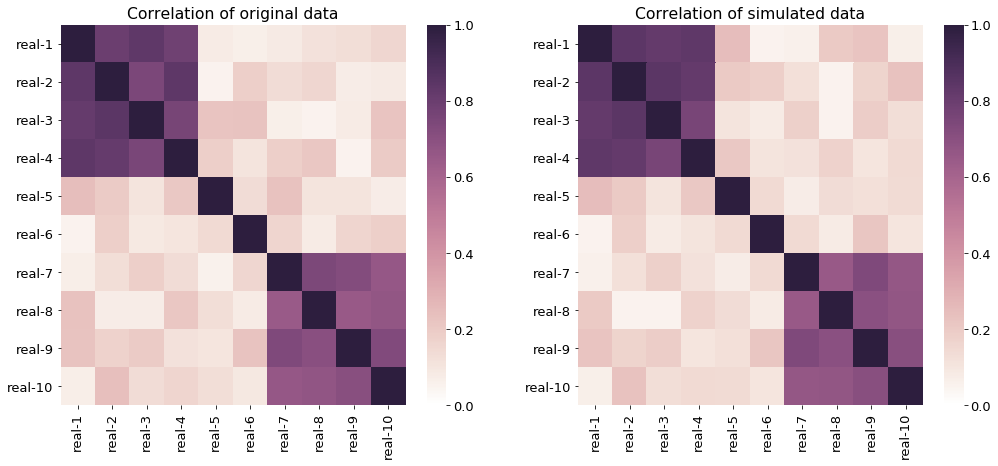

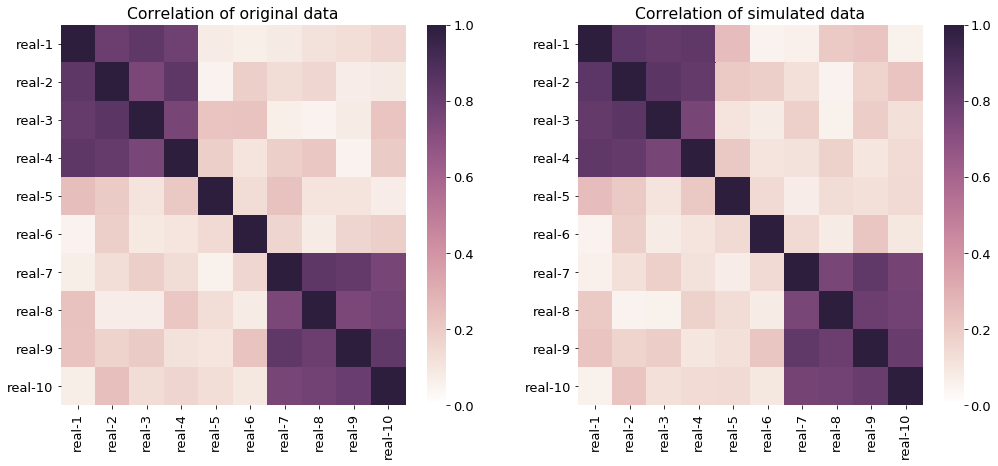

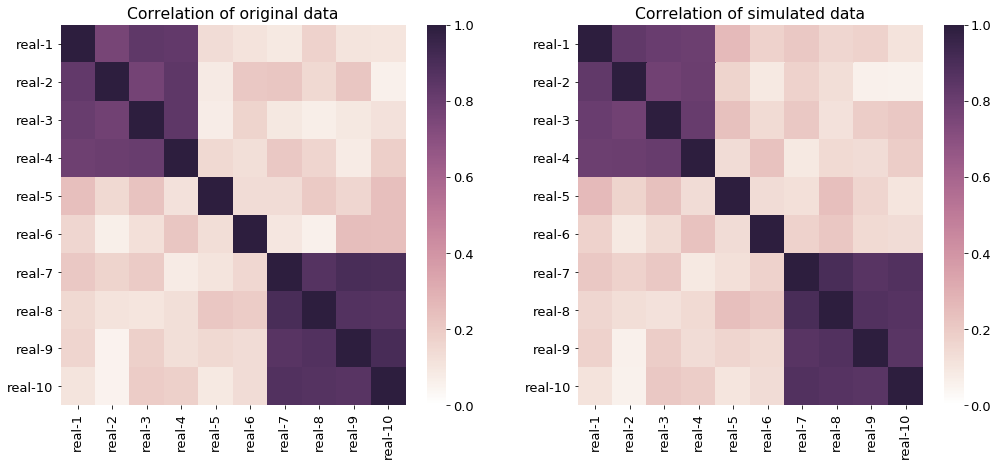

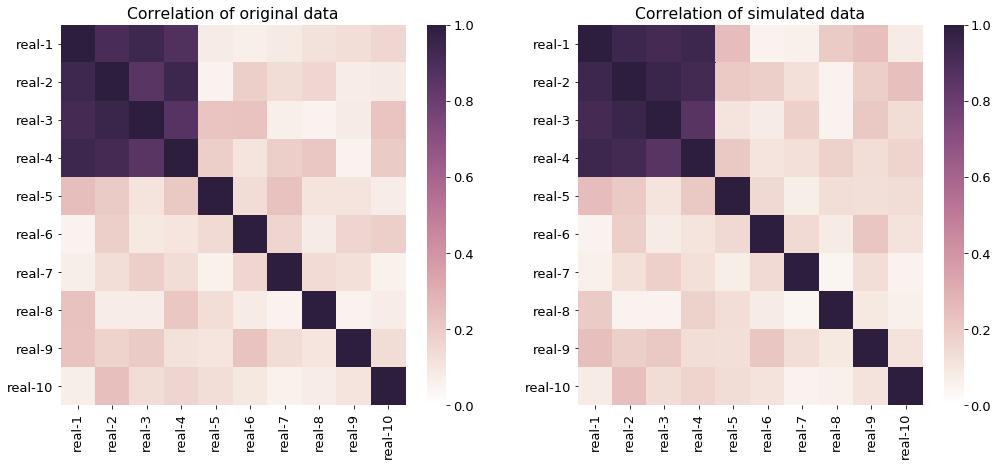

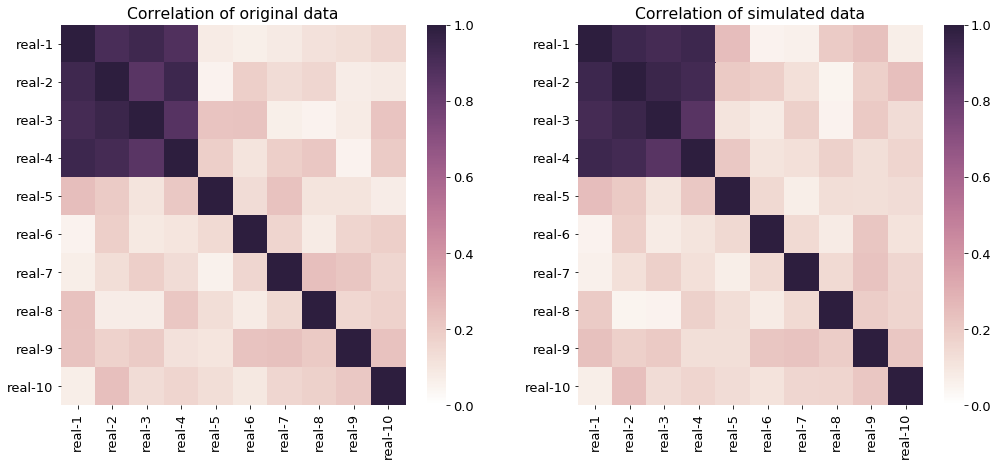

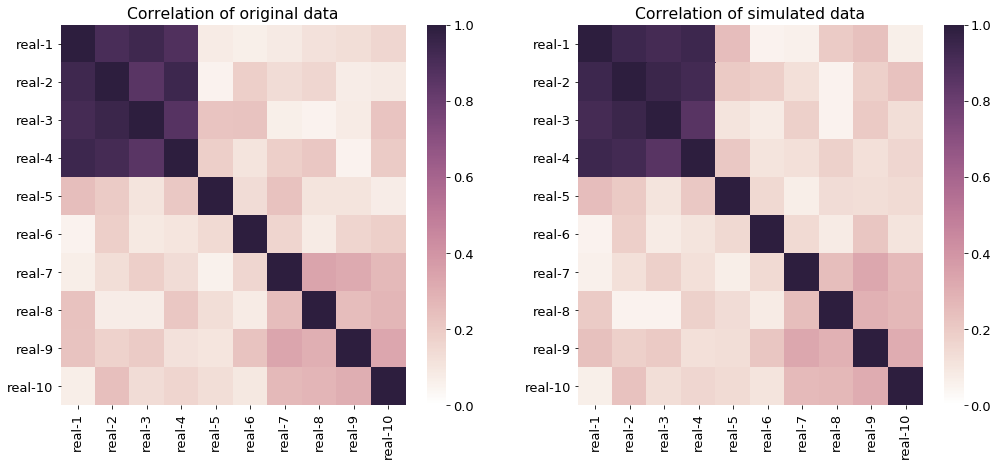

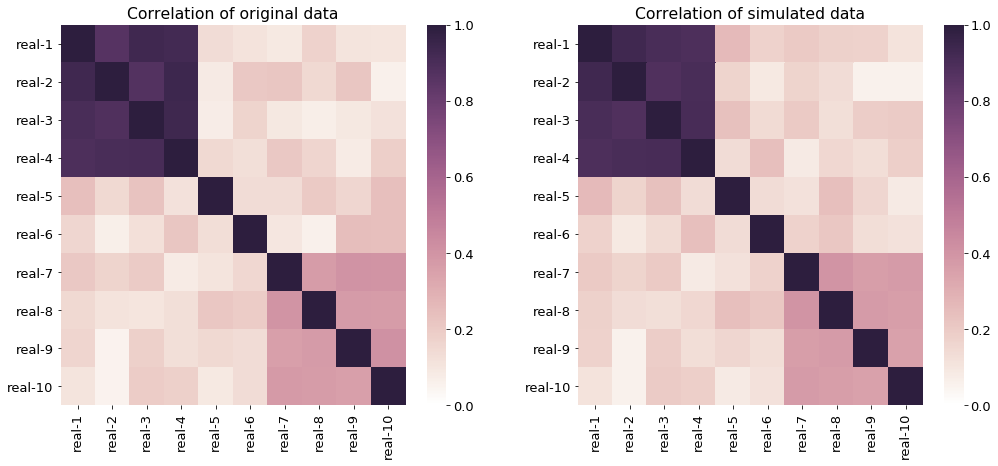

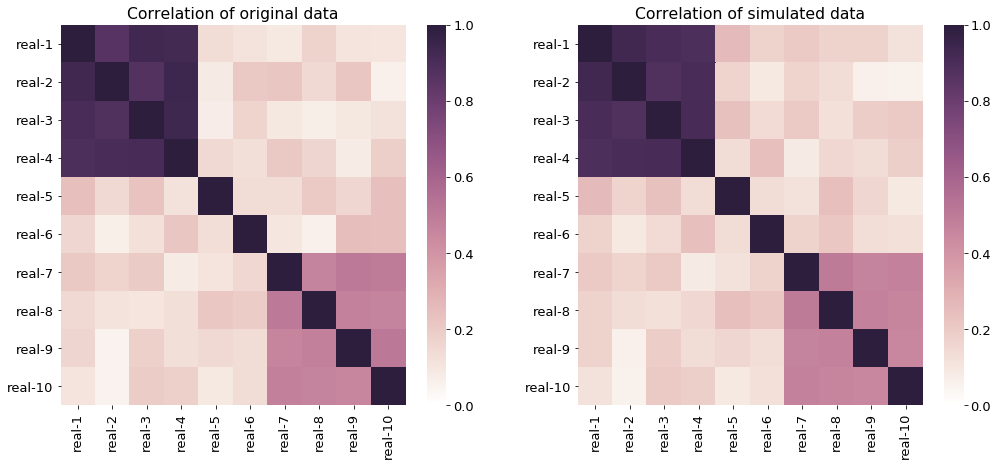

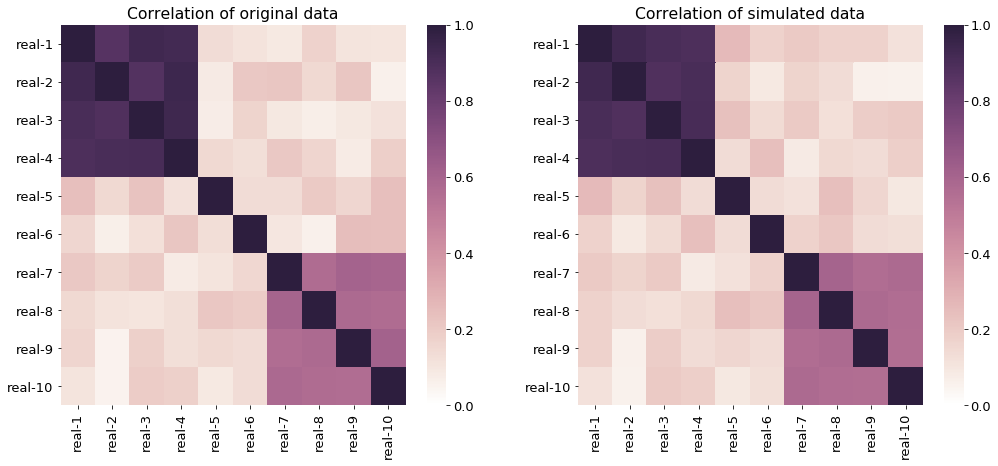

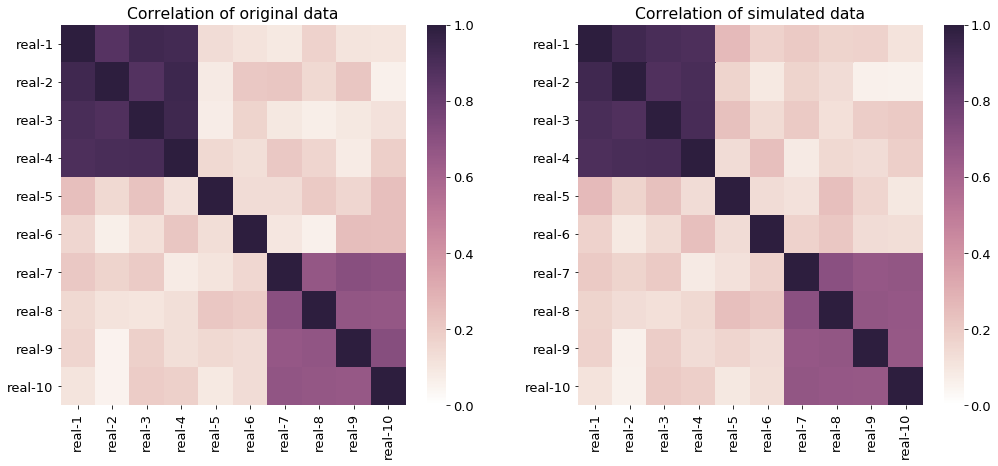

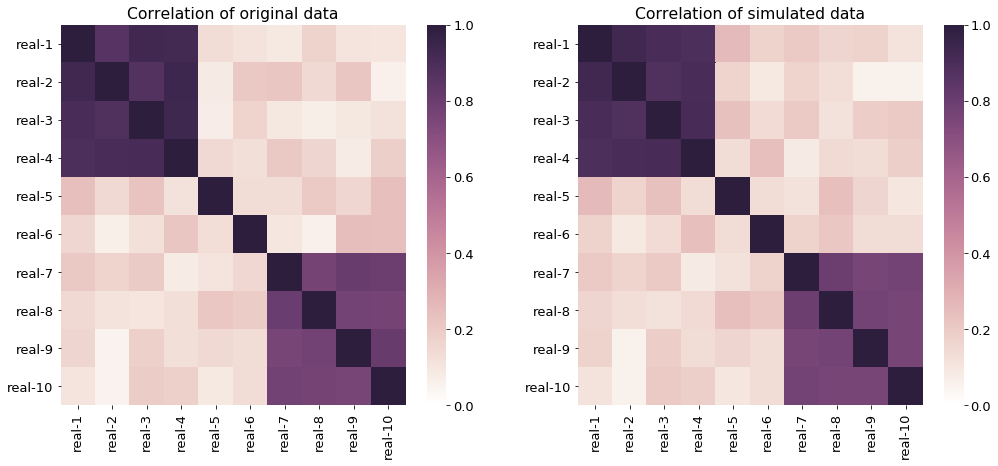

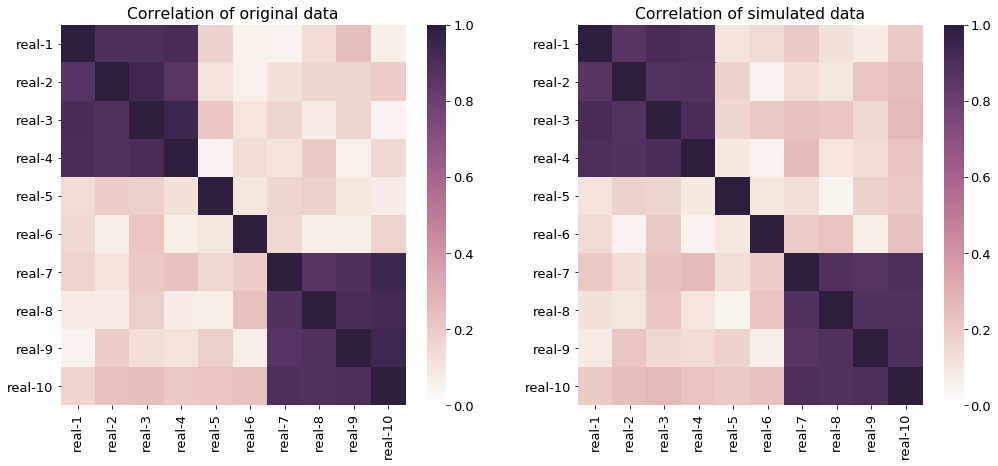

In [71]:
ctr = 0

for c_t in corr_tagret_pool:
    for c_s in corr_sensitive_pool:

        ctr += 1

        C, seed = load_dual_correlation_matrix(dimension=DIMENSION, corr_target=c_t, corr_sensitive=c_s, max_iter=1000)
        X = simulate_multi_dimensional_real_data(NUM_SAMPLES, C, DIMENSION)
        X = pd.DataFrame(X, columns=['real-{}'.format(i + 1) for i in range(X.shape[1])])

        C_sim = X.corr(method='pearson')
        C = pd.DataFrame(C, columns=C_sim.columns, index=C_sim.columns)
        evaluate_simulated_data_by_correlation(C_sim, C)

        dataset[str(ctr)] = {'corr_target': c_t, 'corr_sensitive': c_s, 'data': X, 'seed': seed, 'C_in': C, 'C_sim': C_sim}

In [72]:
save_synthetic_dataset(dataset, name='dataset_3')

### 10D Real: Non-uniform correlation matrices

In [109]:
dataset = defaultdict(dict)

DIMENSION = 10
NUM_SAMPLES = 5000

In [110]:
values = np.array([0.3, 0.6, 0.9])
possible_configs = list(permutations(values))

  0%|          | 0/10000 [00:00<?, ?it/s]


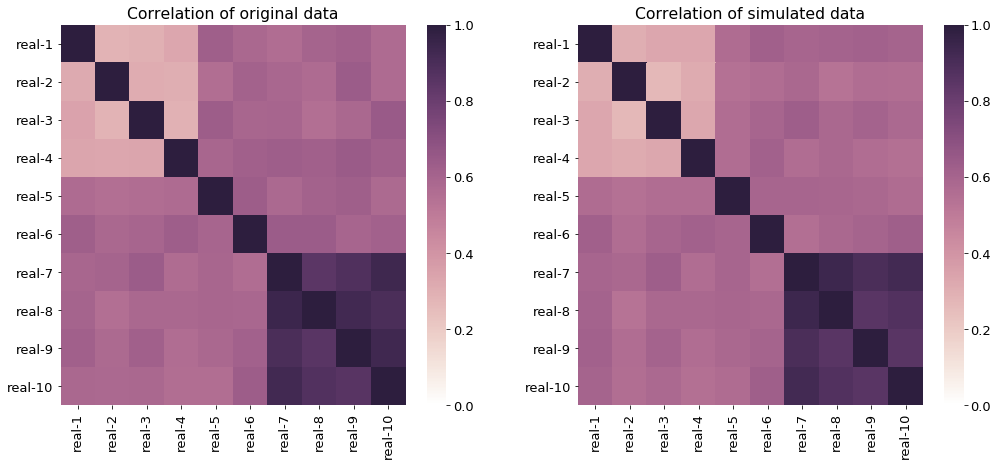

  0%|          | 0/10000 [00:00<?, ?it/s]


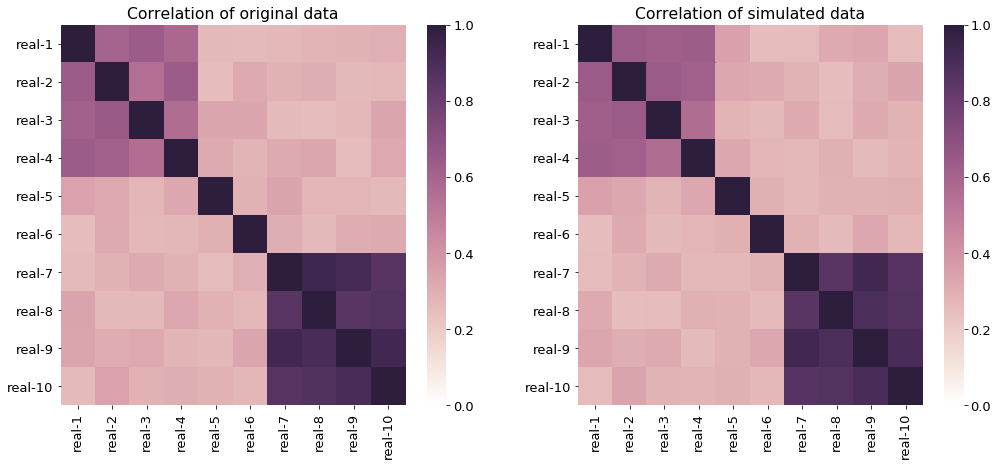

  0%|          | 0/10000 [00:00<?, ?it/s]


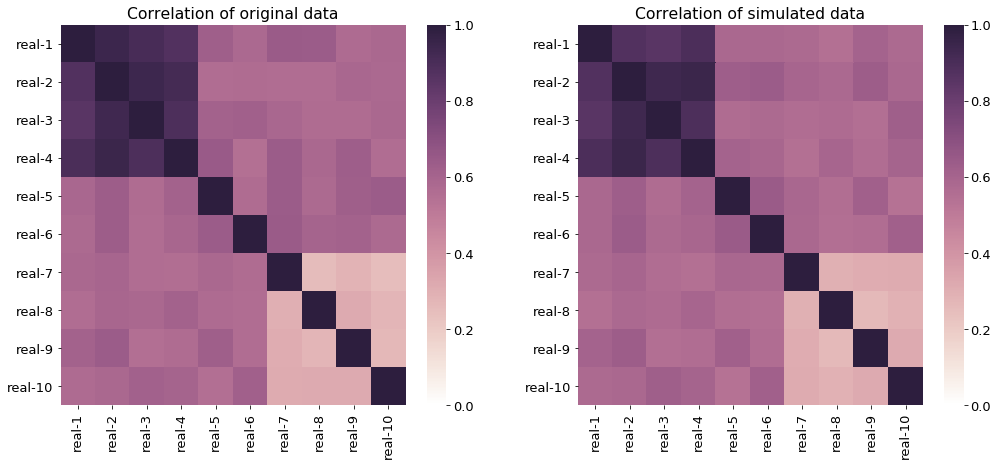

  0%|          | 0/10000 [00:00<?, ?it/s]


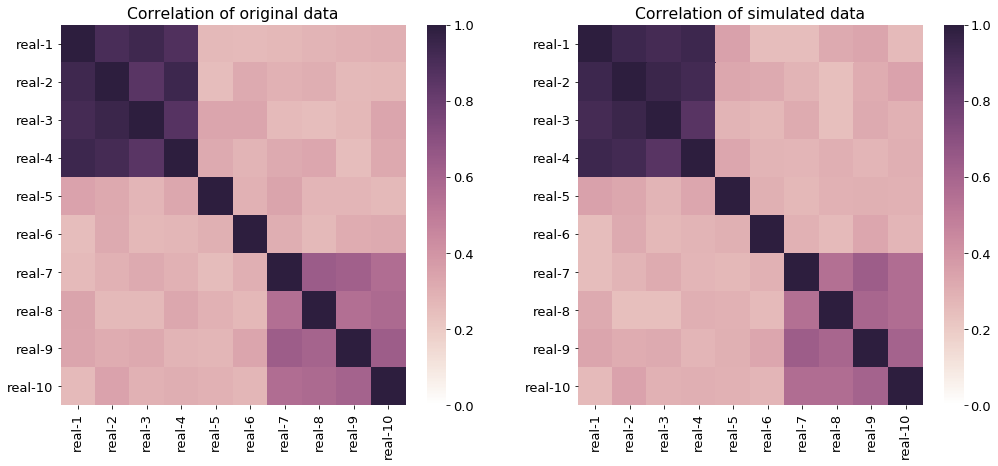

In [111]:
ctr = 0

for x, y, z in possible_configs:
    
    if z == max(x, y, z):
        continue

    ctr += 1

    C, seed = load_nonuniform_correlation_matrix(DIMENSION, northwest=x, southeast=y, rest=z, max_iter=10000)
    X = simulate_multi_dimensional_real_data(NUM_SAMPLES, C, DIMENSION)
    X = pd.DataFrame(X, columns=['real-{}'.format(i + 1) for i in range(X.shape[1])])

    C_sim = X.corr(method='pearson')
    C = pd.DataFrame(C, columns=C_sim.columns, index=C_sim.columns)
    evaluate_simulated_data_by_correlation(C_sim, C)

    dataset[str(ctr)] = {'northwest': x, 'southeast': y, 'rest': z, 'data': X, 'seed': seed, 'C_in': C, 'C_sim': C_sim}


In [112]:
dataset.keys()

dict_keys(['1', '2', '3', '4'])

In [113]:
save_synthetic_dataset(dataset, name='dataset_4')

## Categorical Data

In [14]:
def cramers_v(x, y):

    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]

    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n

    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))

    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)

    val = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

    return val

def compute_cramers_v_matrix(X):

    dim = X.shape[1]
    mat = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            mat[i][j] = cramers_v(X[:, i], X[:, j])

    return mat

def round_of_rating(number):
    return np.round(number * 2) / 2


def discretize_data_by_binning(X, list_of_num_bins):
    
    assert isinstance(list_of_num_bins, list)
    assert len(list_of_num_bins) >= 1
    
    D = X.shape[1]
    
    X_cat = X.copy()
    for d in range(D):
        z = round_of_rating(X_cat[:, d])
        num_bins = np.random.choice(list_of_num_bins)
        temp = list(pd.cut(z, bins=num_bins))
        X_cat[:, d] = le().fit_transform(temp)
    
    return X_cat.astype(int)


def simulate_multi_dimensional_catergorical_data(num_samples, cramers_v_matrix, dimension,
                                                 list_of_num_bins, use_gamma=True, std_dev=1.0, shape=2, scale=2):
    """
    Generates categorical data X such that cramers_v([X_1, X_2, .., X_dimension]) = correlation_matrix
    """
    
    gamma = {
        "shape": shape,
        "scale": scale
    }

    gaussian = {
        "mean": 0,
        "std_dev": std_dev,
    }
    
    gamma_distributions = [gamma]

    assert cramers_v_matrix.shape == (dimension, dimension)
    
    Q = cramers_v_matrix.copy()
    D = dimension
    N = num_samples

    L = np.linalg.cholesky(Q)
    
    L_ = np.square(L)
    Z = np.zeros((N, D))
    
    for d in range(D):
        if use_gamma:
            chosen_distribution = np.random.choice(gamma_distributions)
            shape, scale = chosen_distribution['shape'], chosen_distribution['scale']
            Z[:, d] = np.random.gamma(shape=shape, scale=scale, size=N)
        else:
            mean, std_dev = gaussian['mean'], gaussian['std_dev']
            Z[:, d] = np.random.normal(mean, std_dev, size=N)

    X = np.dot(L, Z.T).T
    
    X_cat = discretize_data_by_binning(X, list_of_num_bins=list_of_num_bins)
    
    return X_cat

#### 10D Categorical data: Non-uniform associations

In [140]:
dataset = defaultdict(dict)

DIMENSION = 10
NUM_SAMPLES = 5000
LIST_OF_NUM_BINS = [2, 4]
STD_DEV = 1.5

In [142]:
values = np.array([0.3, 0.6, 0.9])
possible_configs = list(permutations(values))


  0%|          | 0/10000 [00:00<?, ?it/s]


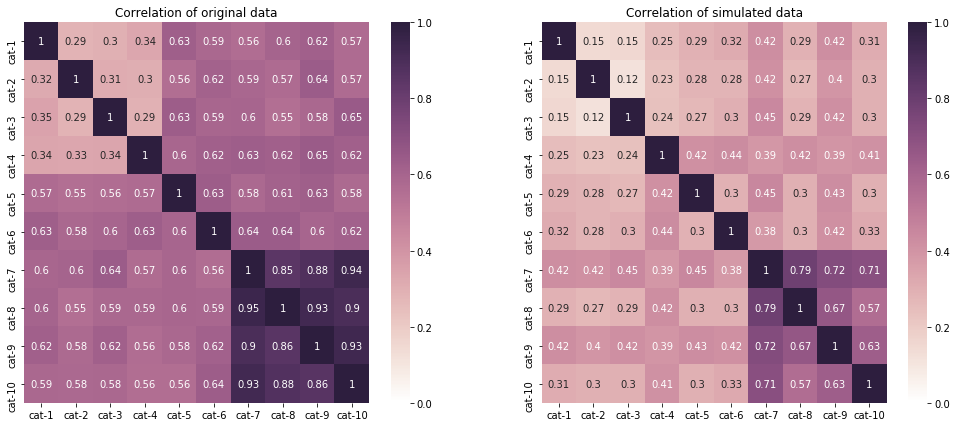


  0%|          | 0/10000 [00:00<?, ?it/s]


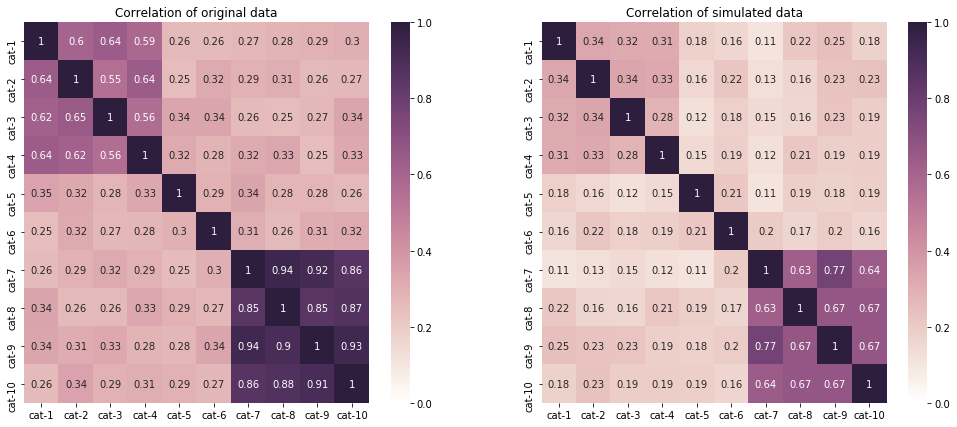


  0%|          | 0/10000 [00:00<?, ?it/s]


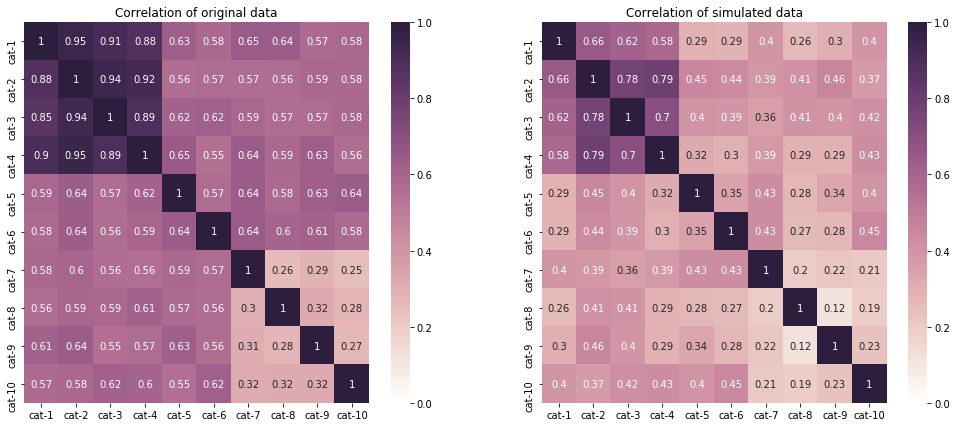


  0%|          | 0/10000 [00:00<?, ?it/s]


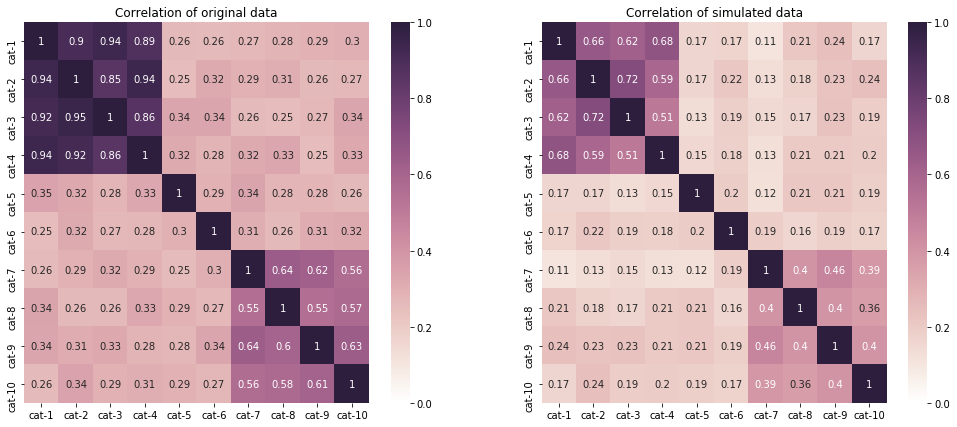

In [143]:
ctr = 0

for x, y, z in possible_configs:
    
    if z == max(x, y, z):
        continue

    ctr += 1

    C, seed = load_nonuniform_correlation_matrix(10, northwest=x, southeast=y, rest=z, max_iter=10000)
    X = simulate_multi_dimensional_catergorical_data(NUM_SAMPLES, C, DIMENSION, LIST_OF_NUM_BINS, False, STD_DEV)

    columns = ['cat-{}'.format(i + 1) for i in range(X.shape[1])]
    X = pd.DataFrame(X, columns=columns)
    
    C_sim = compute_cramers_v_matrix(X.values)
    C_sim = pd.DataFrame(C_sim, columns=columns, index=columns)
    
    C = pd.DataFrame(C, columns=columns, index=columns)
    
    evaluate_simulated_data_by_correlation(C_sim, C, show=True)
    
    dataset[str(ctr)] = {'northwest': x, 'southeast': y, 'rest': z, 'data': X, 'seed': seed, 'C_in': C, 'C_sim': C_sim}

In [144]:
dataset.keys()

dict_keys(['1', '2', '3', '4'])

In [145]:
save_synthetic_dataset(dataset, name='dataset_5')

### Mixed dataset to study impact of LE on correlation and generation

In [13]:
SEED = 0

In [14]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.set_context('paper')

In [15]:
def simulate_mixed_dataset(num_examples, classes_1=None, classes_2=None):
    """
    Generates a dataset with 2 real features and 2 categorical features
    with specific relation between real-2 and cat-1
    """

    MEAN_1, STD_1 = 2, 2.5

    if classes_1 is None:
        classes_1 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
    if classes_2 is None:
        classes_2 = ['q', 's', 't', 'p', 'r']

    np.random.seed(SEED)
    real_1 = np.random.normal(MEAN_1, STD_1, num_examples)
    
    cat_1 = []
    fractions = [0.02, 0.04, 0.08, 0.12, 0.4, 0.12, 0.08, 0.04, 0.02]
    dist_1 = [int(fraction * num_examples) for fraction in fractions]
    dist_1.append(num_examples - sum(dist_1))
    for j, x in enumerate(classes_1):
        cat_1 += [x for i in range(dist_1[j])]

    real_2 = []
    for j, x in enumerate(dist_1):
        real_2 += list(np.random.normal(2 * j, 1, x))

    cat_2 = []
    fractions = [0.15, 0.2, 0.3, 0.15, 0.2]
    dist_2 = [int(fraction * num_examples) for fraction in fractions]
    try:
        for j, x in enumerate(classes_2):
            cat_2 += [x for i in range(dist_2[j])]
    except:
        import pdb; pdb.set_trace()

    data = np.array([[None for i in range(4)] for i in range(num_examples)])
    data[:, 0] = real_1
    data[:, 1] = real_2
    data[:, 2] = cat_1
    data[:, 3] = cat_2
    
    data = pd.DataFrame(data, columns=['real-1', 'real-2', 'cat-1', 'cat-2'])

    return data

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from random import shuffle

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


In [17]:
def visualize_data_distribution(X, real_columns, cat_columns, title):
    
    total_rows = 1
    total_cols = len(real_columns) + len(cat_columns)

    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(title, fontsize=20)
    gs = gridspec.GridSpec(nrows=total_rows, ncols=total_cols)
    
    for j, col in enumerate(real_columns):

        ax = fig.add_subplot(gs[j])

        kwargs = {'cumulative': True}
        sns.distplot(X.values[:, j], ax=ax, hist=False, kde_kws=kwargs)
        ax.set_xlabel(col, fontsize=13)
        ax.grid()
    
    for j, col in enumerate(cat_columns):
        
        ax = fig.add_subplot(gs[j + len(real_columns)])
        sns.countplot(x = col, data = X, palette=("Blues_d"), ax=ax)
        ax.grid()
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
        ax.set_xlabel(ax.get_xlabel(), fontsize=13)

    plt.show()

In [18]:
def plot_correlation_for_mixed_dataset(X):
    Y = MultiColumnLabelEncoder(columns=['cat-1', 'cat-2']).fit_transform(X).astype(float)

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.heatmap(Y.corr(method='pearson'), vmin=-1.0, vmax=1.0, cmap=cmap, annot=True);

In [19]:
X = simulate_mixed_dataset(num_examples=5000)

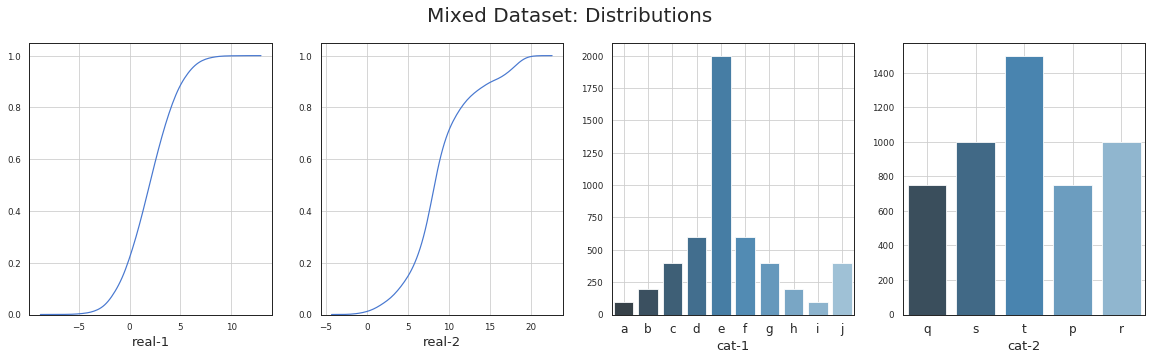

In [20]:
visualize_data_distribution(X, real_columns=['real-1', 'real-2'], cat_columns=['cat-1', 'cat-2'], title='Mixed Dataset: Distributions')

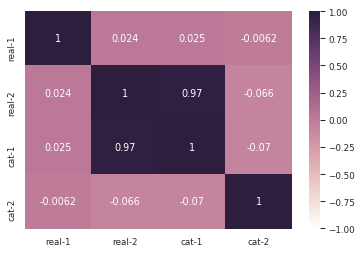

In [21]:
plot_correlation_for_mixed_dataset(X)

In [22]:
NUM_SAMPLES = 5000
dataset = defaultdict(dict)

In [23]:
order = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

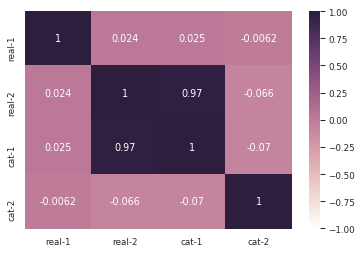

In [25]:
X = simulate_mixed_dataset(num_examples=NUM_SAMPLES, classes_1=order)
plot_correlation_for_mixed_dataset(X)
dataset['sorted'] = {'data': X, 'order': order}

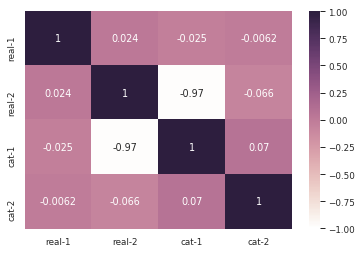

In [26]:
order.sort(reverse=True)
X = simulate_mixed_dataset(num_examples=NUM_SAMPLES, classes_1=order)
plot_correlation_for_mixed_dataset(X)
dataset['inverse sorted'] = {'data': X, 'order': order}

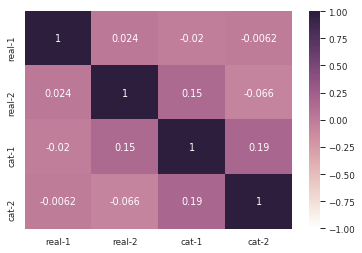

In [30]:
shuffle(order)
X = simulate_mixed_dataset(num_examples=NUM_SAMPLES, classes_1=order)
plot_correlation_for_mixed_dataset(X)
dataset['random'] = {'data': X, 'order': order}

In [31]:
dataset.keys()

dict_keys(['random', 'sorted', 'inverse sorted'])

In [33]:
dataset['random'].keys(), dataset['inverse sorted'].keys(), dataset['sorted'].keys()

(dict_keys(['data', 'order']),
 dict_keys(['data', 'order']),
 dict_keys(['data', 'order']))

In [135]:
save_synthetic_dataset(dataset, name='dataset_6')